# Final Project Deep RL - Preprocess and Training Notebook

---


# Pre-Requisit


Make the noteblook run both locally and on google colab.


In [1]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")
print("CUDA Version:", torch.version.cuda)
print("cuDNN Version:", torch.backends.cudnn.version() if torch.cuda.is_available() else "No cuDNN found")

CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 4050 Laptop GPU
CUDA Version: 12.1
cuDNN Version: 90100


## Setting up COLAB \ JUPYTER Environment


In [2]:
import os
import sys
from pathlib import Path

# Detect if running on Google Colab
try:
    import google.colab
    ON_COLAB = True
except ImportError:
    ON_COLAB = False

if ON_COLAB:
    from IPython import get_ipython
    print("🔄 Running on Google Colab, setting up environment...")

    # Install required packages in Colab
    get_ipython().run_cell_magic('capture', '', """
        !sudo apt-get update
        !sudo apt-get install -y xvfb ffmpeg freeglut3-dev
        !pip install 'imageio==2.4.0'
        !apt-get install python-opengl -y
        !apt install xvfb -y
        !pip install pyvirtualdisplay
        !pip install piglet
        !pip install gymnasium
        !pip install -U --no-cache-dir gdown --pre
        !pip install minigrid
    """)

    # Set up paths for Colab
    BASE_DIR = Path("/content")
    VIDEO_DIR = BASE_DIR / "videos"
    os.makedirs(VIDEO_DIR, exist_ok=True)  # Ensure video directory exists

    # Download the sample video if it doesn't exist
    video_path = BASE_DIR / "MiniGrid-MultiRoom-N6-v0_vid.mp4"
    if not video_path.exists():
        print("📥 Downloading sample video for visualization...")
        os.system("wget -q https://www.dropbox.com/scl/fi/jhkb2y3jw8wgin9e26ooc/MiniGrid-MultiRoom-N6-v0_vid.mp4?rlkey=qtkrmmbk9aiote5z7w4bx6ixi&st=zbr4gk21&dl=1 -O content/MiniGrid-MultiRoom-N6-v0_vid.mp4")

else:
    print("💻 Running locally on Jupyter. No Colab setup needed.")
    
    # Set up paths for local execution
    BASE_DIR = Path("C:/Users/ASUS/OneDrive/MSc MLDS/Reinforcement Learning/Projects/final-project")
    VIDEO_DIR = BASE_DIR / "videos"
    os.makedirs(VIDEO_DIR, exist_ok=True)  # Ensure video directory exists


💻 Running locally on Jupyter. No Colab setup needed.


## Import


In [3]:
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pyvirtualdisplay
import IPython
import base64
import gymnasium
import minigrid
from minigrid.wrappers import RGBImgObsWrapper, RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper, RGBImgPartialObsWrapper
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
print("Global dependencies loaded successfully")

Global dependencies loaded successfully


In [4]:
# our project imports
from minigrid.envs import MultiRoomEnv
import gymnasium as gym
from gymnasium.core import Wrapper

import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import os
import sys
import tqdm
from tqdm.notebook import tqdm
# from cv2 import cvtColor
from pathlib import Path
from abc import ABC, abstractmethod
from typing import Tuple, List, Deque , Optional, Dict, Union, Any
from gymnasium import Env
import importlib
from contextlib import contextmanager
import time
print("Local dependencies loaded successfully")

Local dependencies loaded successfully


In [5]:
# Constants for the environemnt configuration do no change the values
highlight = False
render_mode = "rgb_array"

# Our additional constants
WORK_DIR = Path("C:/Users/ASUS/OneDrive/MSc MLDS/Reinforcement Learning/Projects/final-project")
ACTIONS_SPACES = [0, 1, 2, 5]
ACTIONS_SPACES_MAPPED = {0: 0, 1: 1, 2: 2, 5: 3}  


## CUDA and GPU Configurtaions


To leverage GPU acceleration, we first check if a CUDA-compatible device is available using torch.cuda.is_available(). If a GPU is detected, we retrieve its name and count, ensuring our model can utilize the best available hardware. We also enable CuDNN optimizations (torch.backends.cudnn.benchmark = True and torch.backends.cudnn.enabled = True) to accelerate convolutional operations.

Additionally, we import Automatic Mixed Precision (AMP) from torch.amp, specifically autocast and GradScaler. AMP allows us to speed up training and reduce memory usage by dynamically using lower-precision floating-point arithmetic (e.g., float16) where possible. The autocast function enables mixed-precision calculations within a specified scope, while GradScaler helps prevent underflow issues when computing gradients in lower precision by scaling losses before backpropagation. This improves performance without sacrificing training stability.

Lastly, we set default tensors to be allocated on the GPU (torch.set_default_tensor_type(torch.cuda.FloatTensor)) to reduce CPU-GPU data transfer overhead and maximize efficiency.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.amp import autocast, GradScaler


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    torch.backends.cudnn.benchmark = True  # Use optimized conv operations
    torch.backends.cudnn.enabled = True    # Ensure CuDNN is used
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # Default tensors on GPU

CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 4050 Laptop GPU
CUDA Device Count: 1


c:\Users\ASUS\anaconda3\envs\minigrid-rl\lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


## Display Functions

The cell below contains the video display configuration. No need to make changes here.


In [7]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900), backend=None).start()

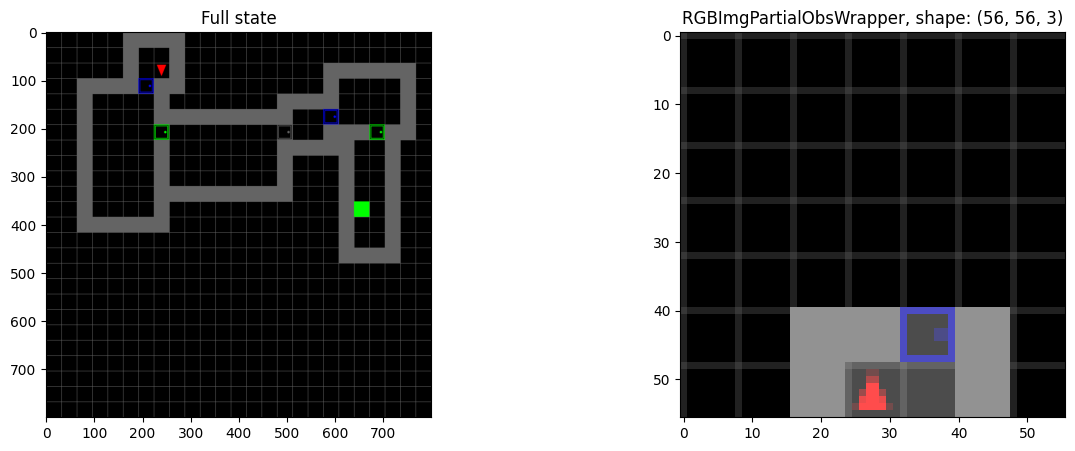

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(obs)
axs[1].title.set_text(f'RGBImgPartialObsWrapper, shape: {obs.shape}')
axs[0].imshow(env.render())
axs[0].title.set_text(f'Full state')
plt.show()

## Initializing the smaller environments


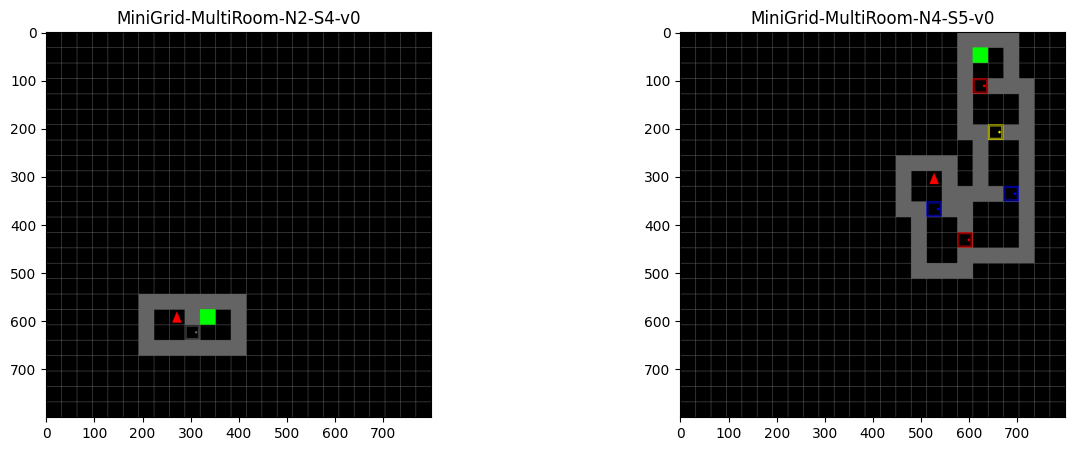

In [9]:
env = gymnasium.make("MiniGrid-MultiRoom-N2-S4-v0", render_mode=render_mode, highlight=highlight)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[0].imshow(env.render())
axs[0].title.set_text(f'MiniGrid-MultiRoom-N2-S4-v0')



env = gymnasium.make("MiniGrid-MultiRoom-N4-S5-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(env.render())
axs[1].title.set_text(f'MiniGrid-MultiRoom-N4-S5-v0')
plt.show()

### Partial Observation Example


In [10]:
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
# video_filename = '/content/vid_partial.mp4'
video_filename = "C:/Users/ASUS/OneDrive/MSc MLDS/Reinforcement Learning/Projects/final-project/videos/fdfdfdfdfdf.mp4"
truncated = False
# Evaluation
with imageio.get_writer(video_filename, fps=10) as video:
  obs, _ = env.reset()
  done = False
  total_reward = 0
  step = 0
  while not truncated:
      action = env.action_space.sample()
      obs, reward, done, truncated  , _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(obs)
      step += 1
      if truncated:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
# embed_mp4(video_filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (56, 56) to (64, 64) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


done reward= 0 num_of_steps= 120


## Implement Algorithms and Training


## Preprocessing


### Environment Controll

We started by create_multiroom_env function for debugging our fundamental classes, controll randomization and progressive learning. Training in complex environments led to unstable performance, making it hard to pinpoint issues in our agent, replay buffer, and training loop. By controlling room count, size, and steps, we could isolate problems, test core functions, and ensure our agent learned step by step. Randomization via seeding prevented overfitting, ensuring robust, generalizable policies. Additionally, get_action_meaning helped interpret outputs, making debugging and analysis more intuitive.


In [11]:
env.unwrapped
env.unwrapped.actions.forward

<Actions.forward: 2>

In [12]:
def unwrap_env(env):
    """
    Recursively unwraps an environment if it is wrapped in multiple layers of wrappers.
    """
    while isinstance(env, Wrapper):
        env = env.env
    return env

from gymnasium import Wrapper
import numpy as np

class RewardShaper(Wrapper):
    """
    A wrapper for MiniGrid environments that adds reward shaping to encourage better learning.
    """

    def __init__(self, env, distance_weight=0.1, revisit_penalty=-0.01, 
                 door_open_reward=0.5, progress_reward=0.2, 
                 no_move_penalty=-0.02, toggle_penalty=-0.05):
        """
        Initializes the reward shaping wrapper.
        """
        super().__init__(env)
        self.distance_weight = distance_weight
        self.revisit_penalty = revisit_penalty
        self.door_open_reward = door_open_reward
        self.progress_reward = progress_reward
        self.no_move_penalty = no_move_penalty
        self.toggle_penalty = toggle_penalty  
        self.visited_positions = set()
        self.opened_doors = set()
        self.previous_pos = None

    def reset(self, **kwargs):
        """
        Resets the environment and clears tracking variables.
        """
        obs, info = self.env.reset(**kwargs)
        self.visited_positions.clear()
        self.opened_doors.clear() 
        self.previous_pos = tuple(self.env.agent_pos)  # Store the starting position

        
        # print(f"🔄 Reset Environment - Agent starts at {self.previous_pos}")
        return obs, info

    def step(self, action):
        prev_pos = tuple(self.env.agent_pos)  # Store the agent's previous position
        obs, reward, done, truncated, info = self.env.step(action)
        agent_pos = tuple(self.env.agent_pos)

        # print(f"\n➡️ Action Taken: {action}")
        # print(f"📍 Previous Position: {prev_pos} -> New Position: {agent_pos}")

        goal_pos = self.env.goal_pos
        goal_visible = self._is_goal_visible()

        # ✅ Compute Euclidean distance to the goal if visible
        if goal_visible:
            new_distance = np.linalg.norm(np.array(agent_pos) - np.array(goal_pos))
            distance_reward = self.distance_weight * (1 / (new_distance + 1))
            reward += distance_reward
            # print(f"🎯 Goal Visible! Distance: {new_distance:.3f}, Added Reward: {distance_reward:.3f}")

        # ✅ Encourage movement when the goal isn't visible
        elif not goal_visible and action == self.env.actions.forward:
            reward += self.progress_reward
            # print(f"🚶 Moved Forward - Progress Reward Applied: {self.progress_reward}")

        # ✅ Handle revisit penalty correctly
        if action == self.env.actions.forward and prev_pos != agent_pos:  # ✅ Ignore rotations!
            if agent_pos in self.visited_positions:
                # print(f"⚠️ Revisited Position Detected: {agent_pos} - Applying Penalty {self.revisit_penalty}")
                reward += self.revisit_penalty
            else:
                # print(f"✅ First Visit to Position: {agent_pos}")
                pass
            self.visited_positions.add(agent_pos)  # ✅ Now add AFTER the check

        # ✅ Penalize actions that do not result in movement
        print("prev_pos:", prev_pos, "agent_pos:", agent_pos)


        # ✅ Force no-move penalty even if step is ignored
        if action == self.env.actions.forward:
            if prev_pos == agent_pos or tuple(self.env.agent_pos) == prev_pos:
                print(f"⛔ No Movement Detected: {prev_pos} -> {agent_pos} (Applying Penalty: {self.no_move_penalty})")
                reward += self.no_move_penalty
        # if prev_pos == agent_pos and action == self.env.actions.forward:
        #     # print(f"⛔ No Movement - Applying No-Move Penalty {self.no_move_penalty}")
        #     reward += self.no_move_penalty

        self.previous_pos = agent_pos

        # ✅ Reward for opening doors (only once per door)
        if action == self.env.actions.toggle:
            if self._is_facing_door():
                door_pos = self._get_front_position()
                if door_pos not in self.opened_doors:
                    reward += self.door_open_reward
                    self.opened_doors.add(door_pos)
                    # print(f"🚪 Opened Door at {door_pos} - Reward Applied: {self.door_open_reward}")
            else:
                reward += self.toggle_penalty
                print(f"❌ Toggle Without Facing Door - Penalty Applied: {self.toggle_penalty}")

        print(f"🏆 Final Reward for Step: {reward:.3f}")
        return obs, reward, done, truncated, info

    def _is_goal_visible(self):
        """
        Checks whether the goal is visible in the agent's current field of view.
        """
        grid, vis_mask = self.env.gen_obs_grid()
        for idx, visible in np.ndenumerate(vis_mask):
            if visible:
                cell = grid.get(*idx)
                if cell and cell.type == 'goal':
                    return True
        return False

    def _is_facing_door(self):
        """Checks if the agent is currently facing a door."""
        front_pos = self.env.front_pos
        cell = self.env.grid.get(*front_pos)  # Directly get cell, handles out-of-bounds
        return cell is not None and cell.type == "door"


In [ ]:
def create_multiroom_env(
    num_rooms: int = 2,
    max_room_size: int = 5,
    render_mode: str = "rgb_array",
    seed: Optional[int] = None,
    max_steps: Optional[int] = None,
    reward_shaping: bool=False,
    distance_weight=0.1,
    revisit_penalty=-0.01,
    door_open_reward=0.5,
    progress_reward=0.2, 
    no_move_penalty=-0.1,
    toggle_penalty=0.0
    ) -> Tuple[Env, np.ndarray]:
    """
    Create a wrapped MiniGrid MultiRoom environment.

    Parameters:
        num_rooms (int): Number of rooms in the environment.
        max_room_size (int): Maximum size of each room.
        render_mode (str): How to render the environment (default "rgb_array").
        seed (int, optional): Seed for environment randomness.

    Returns:
        Tuple[Env, np.ndarray]: A tuple containing:
            - env: The wrapped Gymnasium environment
            - obs: Initial observation from the environment
    
    Raises:
        ValueError: If num_rooms or max_room_size are less than 1
    """
    # Input validation
    if num_rooms < 1:
        raise ValueError("num_rooms must be at least 1")
    if max_room_size < 1:
        raise ValueError("max_room_size must be at least 1")

    # Default truncation limit if not specified
    if max_steps is None:
        max_steps = 20 * num_rooms**2  # Default truncation rule
    
    env = MultiRoomEnv(
        minNumRooms=num_rooms, 
        maxNumRooms=num_rooms, 
        maxRoomSize=max_room_size, 
        render_mode=render_mode
    )

    # Apply the requested wrappers
    if reward_shaping:
        env = RewardShaper(env,distance_weight,revisit_penalty,door_open_reward,progress_reward, no_move_penalty, toggle_penalty)

    env = RGBImgPartialObsWrapper(env)  # Converts observations to partial RGB images
    env = ImgObsWrapper(env)  # Ensures the observation space is image-based

    # Set the maximum number of steps    
    env.unwrapped.max_steps = max_steps



    # Reset environment with optional seed
    obs, _ = env.reset(seed=seed) if seed is not None else env.reset()
    return env, obs

### Display Functions

For advanced debugging purpose we implemented functions that allows us to visualize sequence of frames, compitalbe with MultiRoom API. In additin we implement render_agent_video for visualizing a give agent in a give environment.


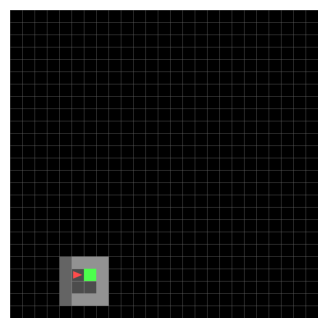

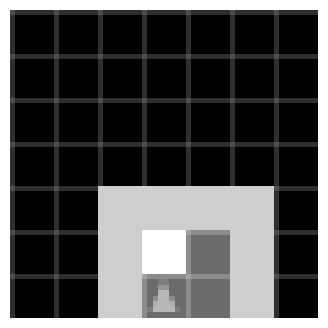

In [14]:
def show_full_frame_rgb(
    env: Env,
    obs: Optional[np.ndarray] = None,
    fig_size: tuple[int, int] = (4, 4),
    title: Optional[str] = None,
    return_rgb: bool = False
) -> None:
    """
    Displays the current frame of the environment in RGB format.

    Parameters:
        env (Env): The Gymnasium environment instance
        obs (Optional[np.ndarray]): The current observation (not used in rendering,
                                  but kept for API consistency)
        fig_size (tuple[int, int]): Size of the figure to display (width, height)
        title (Optional[str]): Title to display above the frame

    Returns:
        None

    Raises:
        ValueError: If the environment doesn't support rendering
        TypeError: If the rendered frame is not a valid image array
    """
    try:
        # Get the current environment frame as an image (RGB array)
        img = env.render()
        
        if not isinstance(img, np.ndarray):
            raise TypeError("Environment render must return a numpy array")

        # Set up the figure
        plt.figure(figsize=fig_size)
        
        # Display the image
        plt.imshow(img)
        
        # Add title if provided
        if title:
            plt.title(title)
            
        # Remove axis labels for better visualization
        plt.axis("off")
        
        # Show the plot
        plt.show()
        plt.close()  # Clean up resources

        if return_rgb:
            return img
        
    except Exception as e:
        plt.close()  # Ensure figure is closed even if there's an error
        raise e

def show_partial_greyscale(
    env: Env,
    obs: np.ndarray,
    fig_size: tuple[int, int] = (4, 4),
    title: Optional[str] = None,
    cmap: str = "gray",
    return_grayscale_array: bool = False
) -> None:
    """
    Displays the partial visible frame in grayscale format.

    Parameters:
        env (Env): The environment instance (kept for API consistency)
        obs (np.ndarray): The current observation to display
        fig_size (tuple[int, int]): Size of the figure to display (width, height)
        title (Optional[str]): Title to display above the frame
        cmap (str): Colormap to use for grayscale display

    Returns:
        None

    Raises:
        ValueError: If the observation is None or invalid shape
        TypeError: If the observation is not a numpy array
    """
    try:
        # Input validation
        if not isinstance(obs, np.ndarray):
            raise TypeError("Observation must be a numpy array")
        
        if obs.size == 0:
            raise ValueError("Observation array is empty")

        # Set up the figure
        plt.figure(figsize=fig_size)
        
        # Convert RGB to grayscale if needed
        if len(obs.shape) == 3 and obs.shape[-1] == 3:
            frame_gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        else:
            frame_gray = obs
            
        # Display the grayscale image
        plt.imshow(frame_gray, cmap=cmap)
        
        # Add title if provided
        if title:
            plt.title(title)
            
        # Remove axis labels for better visualization
        plt.axis("off")
        
        # Show the plot
        plt.show()
        plt.close()  # Clean up resources
        if return_grayscale_array:
            return frame_gray  
        
    except Exception as e:
        plt.close()  # Ensure figure is closed even if there's an error
        raise e

def show_state_full_and_partial(env, obs):
    """
    Displays the full environment view and the partial view on eon top of another.

    Parameters:
        env: The environment instance.
        obs (numpy.ndarray): The observation from the environment.
    """
    # Get full environment render
    full_view = env.render()

    # Create subplot with original and rotated images
    fig, axes = plt.subplots(2, 1, figsize=(3, 6))  # Two views for better comparison
    axes[0].imshow(full_view)
    axes[0].set_title("Full Environment View")
    axes[0].axis("off")
    axes[1].imshow(obs, cmap="gray")
    axes[1].set_title("Partial View")
    axes[1].axis("off")
    plt.show()

def render_agent_video(
    env: Env,
    agent: Any,
    filename: str = "videos/agent_video.mp4",
    fps: int = 16,
    seed: Optional[int] = None,
    frame_size: Tuple[int, int] = (512, 512)
) -> None:
    """
    Runs the agent in the given MultiRoom environment and records a video.

    Parameters:
        env (Env): The environment instance (e.g., MultiRoom).
        agent (Any): The agent instance with a `select_action(state)` method.
        filename (str): Path to save the recorded video.
        fps (int): Frames per second for the video.
        seed (Optional[int]): Seed for reproducibility.
        frame_size (Tuple[int, int]): Desired frame size (width, height) for resizing.

    Returns:
        None

    Raises:
        ValueError: If the environment cannot be rendered.
        FileNotFoundError: If the video directory does not exist.
    """
    # Ensure the directory for the video exists
    video_dir = os.path.dirname(filename)
    if not os.path.exists(video_dir):
        os.makedirs(video_dir)

    print(f"Saving video to: {filename}")

    # Reset environment with optional seed
    if seed is not None:
        env.reset(seed=seed)

    truncated = False  
    total_reward = 0
    step = 0

    try:
        with imageio.get_writer(filename, fps=fps) as video:
            obs, _ = env.reset()
            done = False
            print("!!!!!!")
            while not truncated:
                print("here")
                action = agent.select_action(obs)  # Use agent's action selection
                print(action)
                obs, reward, done, truncated, _ = env.step(action)
                print(obs.shape)
                print("obs", obs)
                
                
                total_reward += reward

                # Render and resize the frame
                frame = env.render()
                if not isinstance(frame, np.ndarray):
                    raise ValueError("Environment render must return a numpy array")

                frame = cv2.resize(frame, frame_size)  # Resize frame
                print(frame)
                video.append_data(frame)

                step += 1
                if done:
                    print(f"Done | Total Reward: {total_reward} | Steps: {step}")
                    break
                elif truncated:
                    print(f"Truncated | Total Reward: {total_reward} | Steps: {step}")
                    break

        # Display the video if running in a notebook
        display(Video(filename, embed=True))

    except Exception as e:
        print(f"Error during video generation: {e}")

env, obs = create_multiroom_env(1, 4)
img_rgb = show_full_frame_rgb(env, obs)
img_grey = show_partial_greyscale(env, obs)

In [15]:
def show_N_steps(env, N, policy=None):
    """
    Runs N steps in the environment, rendering each step.

    Parameters:
        env: The environment instance.
        N (int): Number of steps to execute.
        policy (function): Function that takes obs and returns an action. Defaults to random.
    """
    if policy is None:
        policy = lambda obs: random.choice(ACTIONS_SPACES)  # Default to random actions

    obs, _ = env.reset()  # Ensure the environment starts correctly

    for i in range(N):
        print("--------------------------------------------------")
        print(f"Step {i}")

        action = policy(obs)  # Get action from policy
        mapped_action = ACTIONS_SPACES_MAPPED.get(action, action)
        print(f"Action taken: {action} → Mapped to {mapped_action}")
        obs, reward, done, truncated, info = env.step(mapped_action)

        show_full_frame_rgb(env, obs)
        show_partial_greyscale(env, obs)

        if done or truncated:  # Reset if the episode ends
            print("Environment reset!")
            obs, _ = env.reset()

### FrameStackPreprocess Class

Environments like MiniGrid MultiRoom require the agent to understand spatial dependencies and remember past observations to make optimal decisions. However, standard observations only provide a single frame, making it difficult for the agent to infer motion, detect doors opening, or track past locations. In order to deal with this, especially to encourage the agent to learn the process of open door and moving to the next room, we will implement FrameStackPreprocess. In addition, this class will convert the observation to greyscale becasue the RGB channels doesn't contribute to the learning process and do downsampling to better efficency and generalization (we don't need the fine details of the environment).


In [16]:
class FrameStackPreprocess:
    """
    A wrapper for preprocessing and stacking consecutive frames into different channels.
    - Converts RGB frames to grayscale.
    - Normalizes pixel values.
    - Optionally downsamples to a target size.
    - Stacks the last N frames to capture temporal information.

    Parameters:
        num_frames (int): Number of frames to stack.
        img_size (Tuple[int, int]): Original (Height, Width) of frames before processing.
        downsample_size (Tuple[int, int]): Target (Height, Width) after downsampling.
    """
    

    def __init__(self, num_frames: int = 3, img_size: Tuple[int, int] = (56, 56), 
                 downsample_size: Tuple[int, int] = (14, 14)) -> None:
        self.num_frames: int = num_frames
        self.frames: deque[np.ndarray] = deque(maxlen=num_frames)  # Store last N frames
        self.img_size: Tuple[int, int] = img_size  # Ensure all frames have the same shape
        self.downsample_size: Tuple[int, int] = downsample_size  # Target downsampling resolution

    def _convert_to_grayscale(self, frame: np.ndarray) -> np.ndarray:
        """
        Converts an RGB frame to grayscale.

        Args:
            frame (np.ndarray): Input RGB frame with shape (H, W, 3), dtype=np.uint8.

        Returns:
            np.ndarray: Grayscale frame with shape (H, W), dtype=np.uint8.
        """
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        return frame_gray  # Shape: (H, W)

    def _downsample(self, frame: np.ndarray) -> np.ndarray:
        """
        Resizes the grayscale frame to the target downsampling size.

        Args:
            frame (np.ndarray): Input grayscale frame with shape (H, W), dtype=np.uint8.

        Returns:
            np.ndarray: Downsampled frame with shape (downsample_size[0], downsample_size[1]), dtype=np.uint8.
        """
        return cv2.resize(frame, self.downsample_size, interpolation=cv2.INTER_AREA)

    def preprocess(self, frame: np.ndarray) -> np.ndarray:
        """
        Applies grayscale conversion and downsampling to an input RGB frame.

        Args:
            frame (np.ndarray): Input RGB frame with shape (H, W, 3), dtype=np.uint8.

        Returns:
            np.ndarray: Processed frame with shape (downsample_size[0], downsample_size[1]), dtype=np.uint8.
        """
        if isinstance(frame, dict):  # Extract 'image' key if necessary
            print("got dictionary and not frame!")
            frame = frame['image']
        gray_frame: np.ndarray = self._convert_to_grayscale(frame)
        return self._downsample(gray_frame)

    def reset(self, first_frame: np.ndarray) -> np.ndarray:
        """
        Initializes the frame stack with copies of the first preprocessed frame.

        Args:
            first_frame (np.ndarray): First RGB frame with shape (H, W, 3), dtype=np.uint8.

        Returns:
            np.ndarray: Stacked frames with shape (num_frames, downsample_size[0], downsample_size[1]), dtype=np.uint8.
        """
        if isinstance(first_frame, dict):  # Extract 'image' if needed
            print("got dictionary and not frame!")
            first_frame = first_frame['image']
        processed_frame: np.ndarray = self.preprocess(first_frame)
        for _ in range(self.num_frames):
            self.frames.append(processed_frame)
        return np.stack(self.frames, axis=0)

    def update(self, new_frame: np.ndarray) -> np.ndarray:
        """
        Adds a new processed frame to the stack and removes the oldest.

        Args:
            new_frame (np.ndarray): New RGB frame with shape (H, W, 3), dtype=np.uint8.

        Returns:
            np.ndarray: Updated stacked frames with shape (num_frames, downsample_size[0], downsample_size[1]), dtype=np.uint8.
        """
        processed_frame: np.ndarray = self.preprocess(new_frame)
        self.frames.append(processed_frame)
        
        return np.stack(self.frames, axis=0)


    def get_stack(self) -> np.ndarray:
        """
        Retrieves the current stack of frames.

        Returns:
            np.ndarray: Current stacked frames with shape (num_frames, downsample_size[0], downsample_size[1]), dtype=np.uint8.
        """
        return np.stack(self.frames, axis=0)




env, obs = create_multiroom_env(1, 50)
frame_stack=FrameStackPreprocess(num_frames=1,downsample_size=(7,7))
frame_stack.reset(obs)
frame_stack.get_stack().shape

(1, 7, 7)

#### Test FrameStackPreprocess Class

To make sure that this fundemental class has no bug and doesn't miss crucial information for learning, we will explicitly check how the stack looks in every state in this simple environment when acting allways forward" with 1 big room with the reward in the other side.


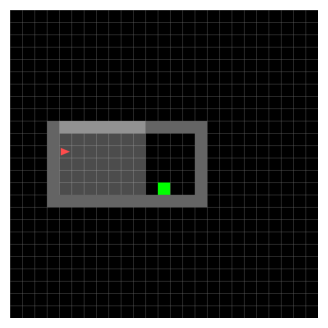

In [17]:
env, obs = create_multiroom_env(1, 50, seed=333)
show_full_frame_rgb(env, obs)

Let's have a look on the stack in the 7 first step focusing on the deque mechanism:


prev_pos: (np.int64(4), np.int64(11)) agent_pos: (np.int64(5), np.int64(11))
🏆 Final Reward for Step: 0.200
3
prev_pos: (np.int64(5), np.int64(11)) agent_pos: (np.int64(6), np.int64(11))
🏆 Final Reward for Step: 0.013
3
prev_pos: (np.int64(6), np.int64(11)) agent_pos: (np.int64(7), np.int64(11))
🏆 Final Reward for Step: 0.015
3
prev_pos: (np.int64(7), np.int64(11)) agent_pos: (np.int64(8), np.int64(11))
🏆 Final Reward for Step: 0.017
3
prev_pos: (np.int64(8), np.int64(11)) agent_pos: (np.int64(9), np.int64(11))
🏆 Final Reward for Step: 0.019
3
prev_pos: (np.int64(9), np.int64(11)) agent_pos: (np.int64(10), np.int64(11))
🏆 Final Reward for Step: 0.022
3
prev_pos: (np.int64(10), np.int64(11)) agent_pos: (np.int64(11), np.int64(11))
🏆 Final Reward for Step: 0.024
3


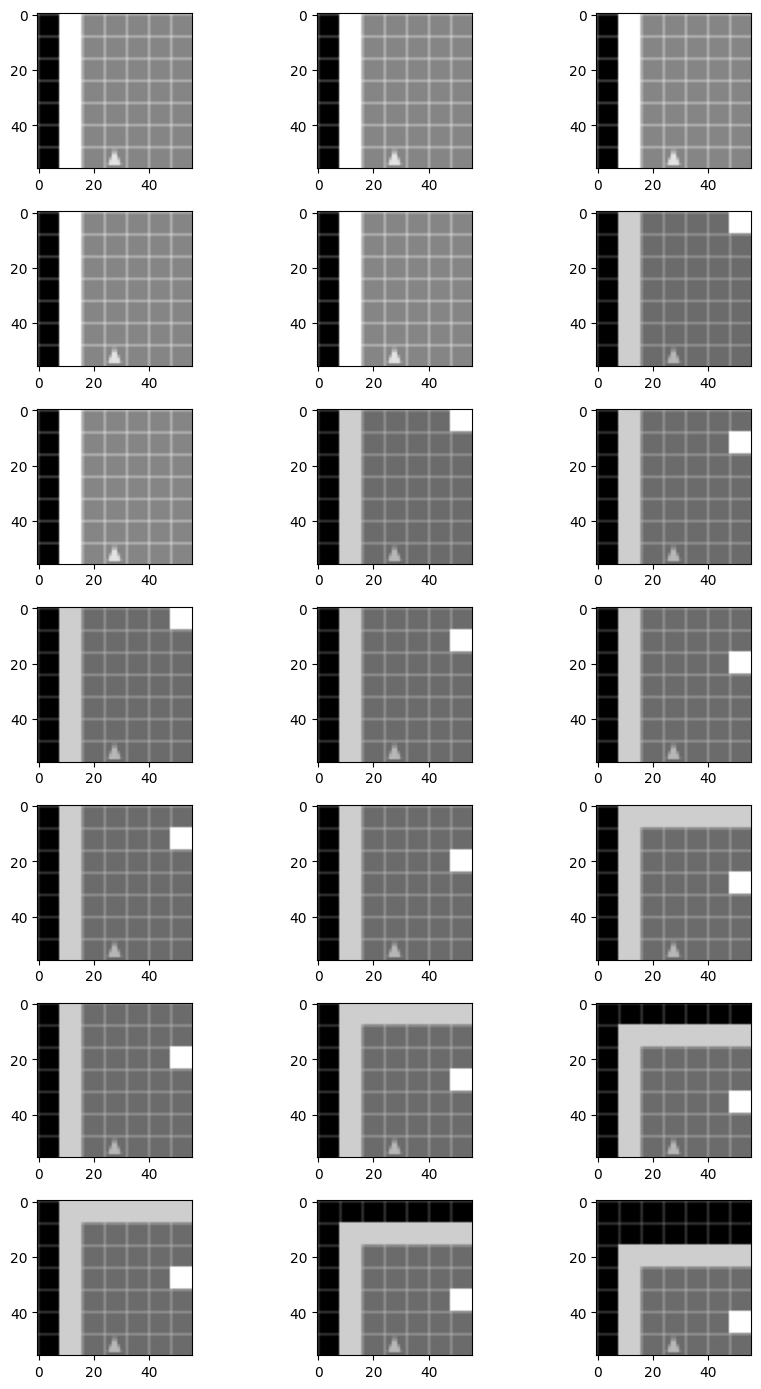

In [21]:
env, obs = create_multiroom_env(1, 50, seed=333, reward_shaping=True)
frame_stack = FrameStackPreprocess(num_frames=3,downsample_size=(56, 56))
frame_stack.reset(obs)
frame_stack.get_stack().shape

action = 2 # Always move forward

import matplotlib.pyplot as plt

def visualize_frame_stack(env, preprocessor, policy, N=7):
    """
    Runs N iterations, updates FrameStackPreprocess, and directly plots stack positions.

    Parameters:
        env: The MiniGrid environment (already initialized).
        preprocessor: Instance of FrameStackPreprocess.
        policy: Function that returns the action to take.
        N: Number of iterations.

    Returns:
        None (displays plots).
    """
    fig, axes = plt.subplots(N, preprocessor.num_frames, figsize=(9, 2 * N))  # N rows, num_frames columns

    for i in range(N):
        action = policy(env)  # Get action from policy
        obs, _, _, _, _ = env.step(action)  # Step in environment
        stacked_frames = preprocessor.update(obs)  # Update the stack
        print(preprocessor.num_frames)
        if preprocessor.num_frames > 1:
            for j in range(preprocessor.num_frames):
                axes[i, j].imshow(stacked_frames[j], cmap="gray")
        else:
            axes[i].imshow(stacked_frames[0], cmap="gray")  # Directly show the single frame

    plt.tight_layout()
    plt.show()



visualize_frame_stack(env, frame_stack, lambda env: 2)

#### Test RewardShaper Wrapper


In [22]:
env, obs = create_multiroom_env(1, 50, seed=333)
print(f"Created environment: {env}")
print(f"Type of env: {type(env)}")  # Check initial type

unwrapped_env = unwrap_env(env)
print(f"Unwrapped environment: {unwrapped_env}")
print(f"Type of unwrapped_env: {type(unwrapped_env)}")  # Should be MultiRoomEnv


assert isinstance(unwrapped_env, MultiRoomEnv), "unwrap_env is not working correctly!"
print("unwrap_env is working correctly!")


Created environment: <ImgObsWrapper<RGBImgPartialObsWrapper<MultiRoomEnv instance>>>
Type of env: <class 'minigrid.wrappers.ImgObsWrapper'>
Unwrapped environment: <MultiRoomEnv instance>
Type of unwrapped_env: <class 'minigrid.envs.multiroom.MultiRoomEnv'>
unwrap_env is working correctly!


In [23]:
def unwrap_to_reward_shaper(env):
    """ Recursively unwraps the environment to access RewardShaper. """
    while not isinstance(env, RewardShaper):
        env = env.env
    return env


In [28]:


env, obs = create_multiroom_env(
    num_rooms=1, max_room_size=4, seed=4, reward_shaping=True,
    progress_reward=0.0,  
    distance_weight=0.0,  
    revisit_penalty=0.0,  
    door_open_reward=0.0,  
    no_move_penalty=-0.1,  # ✅ Only penalty active
    toggle_penalty=0.0
)



# ✅ Take a forward action (should NOT move and should get penalty)
action_forward = env.unwrapped.actions.forward
obs, reward, done, truncated, info = env.step(action_forward)

if reward != -0.1:
    raise AssertionError(f"❌ No-move penalty NOT applied! Expected -0.1, but got {reward:.3f}")

print(f"✅ Forward action into a wall correctly applied penalty: {reward:.3f}")

# ✅ Take a turn action (should NOT apply any penalty)
action_turn = env.unwrapped.actions.left  # or `env.unwrapped.actions.right`
obs, reward, done, truncated, info = env.step(action_turn)
new_pos_after_turn = tuple(env.agent_pos)

# ✅ Check turning
if new_pos_after_turn != initial_pos:
    raise AssertionError(f"❌ Agent moved unexpectedly while turning! {initial_pos} -> {new_pos_after_turn}")

if reward != 0.0:
    raise AssertionError(f"❌ Unexpected penalty applied for turning! Expected 0.0, but got {reward:.3f}")

print(f"✅ Turning correctly does NOT apply a penalty: {reward:.3f}")

print("✅ All tests passed!")





prev_pos: (np.int64(21), np.int64(13)) agent_pos: (np.int64(21), np.int64(13))
⛔ No Movement Detected: (np.int64(21), np.int64(13)) -> (np.int64(21), np.int64(13)) (Applying Penalty: -0.02)
🏆 Final Reward for Step: -0.020


AssertionError: ❌ No-move penalty NOT applied! Expected -0.1, but got -0.020

In [ ]:
agent_face_wall, _ = create_multiroom_env(1, 4, seed=423423, reward_shaping=True)
show_full_frame_rgb(agent_face_wall) 

In [ ]:
import numpy as np

# ✅ Create environments: one with a visible goal, one without
observed_goal_env, _ = create_multiroom_env(1, 4, seed=333, reward_shaping=True)  # Goal should be visible
show_full_frame_rgb(observed_goal_env)
unobserved_goal_env, _ = create_multiroom_env(1, 4, seed=1, reward_shaping=True)  # Goal should NOT be visible
show_full_frame_rgb(unobserved_goal_env)

# ✅ Unwrap the environments
observed = unwrap_to_reward_shaper(observed_goal_env)
unobserved = unwrap_to_reward_shaper(unobserved_goal_env)

# ✅ Verify goal visibility
if not observed._is_goal_visible():
    raise AssertionError("❌ Goal should be visible but was not detected!")
if unobserved._is_goal_visible():
    raise AssertionError("❌ Goal should NOT be visible but was detected!")

print("✅ _is_goal_visible() correctly identifies goal visibility!")


In [ ]:
import numpy as np

# ✅ Create environments with different door visibility cases
see_door_facing_door, _ = create_multiroom_env(2, 4, seed=333, reward_shaping=True)  # Should be facing a door
show_full_frame_rgb(see_door_facing_door)

see_door_no_facing_door, _ = create_multiroom_env(2, 8, seed=2, reward_shaping=True)  # Should see but not face a door
show_full_frame_rgb(see_door_no_facing_door)

no_see_door_no_facing_door, _ = create_multiroom_env(2, 4, seed=1, reward_shaping=True)  # Should neither see nor face a door
show_full_frame_rgb(no_see_door_no_facing_door)

def unwrap_to_reward_shaper(env):
    """ Recursively unwraps the environment to access RewardShaper. """
    while not isinstance(env, RewardShaper):
        env = env.env
    return env

# ✅ Unwrap environments
facing_door_env = unwrap_to_reward_shaper(see_door_facing_door)
seeing_door_not_facing_env = unwrap_to_reward_shaper(see_door_no_facing_door)
no_door_env = unwrap_to_reward_shaper(no_see_door_no_facing_door)

# ✅ Check and assert door-facing conditions
assert facing_door_env._is_facing_door(), "❌ Expected to be FACING a door but is not!"
assert seeing_door_not_facing_env._is_facing_door() == False, "❌ Expected to SEE a door but NOT be facing it still return false!"
assert no_door_env._is_facing_door() == False, "❌ Expected to NEITHER SEE nor FACE a door!"

print("✅ _is_facing_door() correctly identifies door-facing situations!")


In [ ]:
import numpy as np

# ✅ Create environment with reward shaping, setting only relevant rewards
env, obs = create_multiroom_env(
    num_rooms=1, max_room_size=50, seed=333, reward_shaping=True,
    progress_reward=0.2,  # Encourage movement when goal isn't visible
    distance_weight=0.1,  # Reward based on getting closer to the goal
    revisit_penalty=0.0, door_open_reward=0.0, 
    no_move_penalty=0.0, toggle_penalty=0.0
)

# show_full_frame_rgb(env, obs)  # Initial frame

# ✅ Unwrap to access RewardShaper
unwrapped_env = env
while not isinstance(unwrapped_env, RewardShaper):
    unwrapped_env = unwrapped_env.env

# ✅ Ensure goal is NOT visible initially
goal_visible = unwrapped_env._is_goal_visible()
assert not goal_visible, "❌ Goal should NOT be visible initially!"

# ✅ Store initial agent and goal positions
goal_pos = np.array(unwrapped_env.env.goal_pos)

# ✅ Loop to test movement and reward calculation
previous_pos = np.array(unwrapped_env.env.agent_pos)
for step in range(10):  # Maximum steps to prevent infinite loop
    print("----------------------------------------------------------")
    action_forward = env.unwrapped.actions.forward
    obs, reward, done, truncated, info = env.step(action_forward)
    show_full_frame_rgb(env)  # Debug frame
    
    # ✅ Update position after movement
    new_pos = np.array(unwrapped_env.env.agent_pos)
    
    # ✅ Check if goal is visible
    goal_visible = unwrapped_env._is_goal_visible()
    
    if goal_visible:
        print(f"✔ Goal became visible at step {step + 1}")

        # ✅ Compute expected **inverse Euclidean distance reward**
        new_distance = np.linalg.norm(new_pos - goal_pos)
        expected_distance_reward = 0.1 * (1 / (new_distance + 1))

        print(f"📏 Step Calculation (Test Script):")
        print(f"   - Agent Position: {new_pos}")
        print(f"   - Goal Position: {goal_pos}")
        print(f"   - Euclidean Distance: {new_distance:.3f}")
        print(f"   - Expected Reward: {expected_distance_reward:.6f}")
        print(f"   - Actual Reward: {reward:.6f}")

        # ✅ Check if the distance-based reward is correct
        assert np.isclose(reward, expected_distance_reward, atol=1e-3), \
            f"❌ Expected distance reward {expected_distance_reward:.6f}, got {reward:.6f}."

        print(f"✔ Distance-based reward correct: {reward:.6f} (Expected: {expected_distance_reward:.6f})")

    else:
        # ✅ Ensure movement reward is applied correctly
        assert np.isclose(reward, 0.2, atol=1e-3), \
            f"❌ Expected reward 0.2, got {reward:.6f} when moving forward."
        print(f"✔ Moving forward step {step + 1}: Reward = {reward:.6f}")

    # ✅ Update previous position for next iteration
    previous_pos = new_pos


In [ ]:
four_tiles_room_without_goal, _ = create_multiroom_env(2, 4, seed=1, reward_shaping=True)  # Should neither see nor face a door
show_full_frame_rgb(four_tiles_room_without_goal)

In [ ]:
import numpy as np

# ✅ Create the specific test environment
test_env, _  = create_multiroom_env(
    2, 4, seed=1, reward_shaping=True,
    progress_reward=0.0,  # No extra movement reward
    distance_weight=0.0,  # No distance-based reward
    revisit_penalty=-0.1, door_open_reward=0.0, 
    no_move_penalty=0.0, toggle_penalty=0.0
)

def unwrap_to_reward_shaper(env):
    """ Recursively unwraps the environment to access RewardShaper. """
    while not isinstance(env, RewardShaper):
        env = env.env
    return env

# ✅ Unwrap the environment
env = unwrap_to_reward_shaper(test_env)

# ✅ Store initial position
initial_pos = tuple(env.env.agent_pos)
total_penalty = 0  # Track total penalty
counter = 0  # Initialize counter

# ✅ Apply the movement pattern: left, forward, left, forward (repeat 3 times)
for i in range(3):  
    print("-----------------------------------------------------------------")
    print(f"🌀 Loop {i+1}")
    
    for step, action in enumerate([env.unwrapped.actions.left, env.unwrapped.actions.forward] * 4):
        counter += 1  # Properly increments the total step count
        print(f"*****************🔢 Total Iterations: {counter}*****************")
        show_full_frame_rgb(env)
        prev_pos = tuple(env.env.agent_pos)  # Store previous position
        obs, reward, done, truncated, info = env.step(action)
        print("reward:", reward)
        # ✅ The revisit penalty should already be inside `reward`

# ✅ Final assertion

print("✅ Revisit penalty correctly applies when revisiting positions!")


In [ ]:
import numpy as np

# ✅ Create the specific test environment
test_env, _ = create_multiroom_env(
    2, 4, seed=1, reward_shaping=True,
    progress_reward=0.0,  # No extra movement reward
    distance_weight=0.0,  # No distance-based reward
    revisit_penalty=-0.1, door_open_reward=0.0, 
    no_move_penalty=0.0, toggle_penalty=0.0
)

def unwrap_to_reward_shaper(env):
    """ Recursively unwraps the environment to access RewardShaper. """
    while not isinstance(env, RewardShaper):
        env = env.env
    return env

# ✅ Unwrap the environment
env = unwrap_to_reward_shaper(test_env)

# ✅ Store initial position
initial_pos = tuple(env.env.agent_pos)
total_penalty = 0  # Track total penalty
counter = 0  # Initialize counter

# ✅ Apply the movement pattern: left, forward, left, forward (repeat 3 times)
for step, action in enumerate([env.unwrapped.actions.left,
                                env.unwrapped.actions.forward,
                                env.unwrapped.actions.left,
                                env.unwrapped.actions.forward,
                                env.unwrapped.actions.left,
                                env.unwrapped.actions.forward,
                                env.unwrapped.actions.left,
                                env.unwrapped.actions.forward,
                                env.unwrapped.actions.left,
                                env.unwrapped.actions.forward]
                                ):
    counter += 1  # Properly increments the total step count
    print(f"*****************🔢 Total Iterations: {counter}*****************")
    show_full_frame_rgb(env)
    prev_pos = tuple(env.env.agent_pos)  # Store previous position before taking action
    obs, reward, done, truncated, info = env.step(action)
    current_pos = tuple(env.env.agent_pos)  # Current position after the step    
    print(f"🟢 Step {step+1}: Action {action}, Reward: {reward:.3f}, Position: {current_pos}")


As we can see, the stack work well, the transformation of the image still allows to distinct between the tiles of wall, open tile, doors and goal.
Now lets check the downsampling mechanism to reduce resolution for more efficent learning and better visualiztion:


In [ ]:
env, obs = create_multiroom_env(1, 50, seed=333, reward_shaping=True)
frame_stack = FrameStackPreprocess(downsample_size=(7, 7))
frame_stack.reset(obs)
frame_stack.get_stack().shape
visualize_frame_stack(env, frame_stack, lambda env: 2, N=2)

All in all - a downsampled to 7x7x(frame length) geyscaled stacke frame going to be our input to the model.


## Implementing DQN


Our implementation of PER DDQN follows a modular design, ensuring flexibility and clarity. The **QNet** class defines the neural network architecture for estimating Q-values. The **ReplayBuffer** class efficiently stores and retrieves experiences, supporting both standard and Prioritized Experience Replay (PER). The **FrameStackPreprocess** class processes and stacks observations, enhancing temporal awareness. The **BaseAgent** class provides a general reinforcement learning agent framework, while the DQNAgent extends it to implement Deep Q-Learning with Double DQN support. The **Trainer** class manages training, evaluation, and logging, coordinating interactions between the environment, agent experience buffer and allow video saving for debugging.


### QNet Classes

Here we implement the Neural Network Components of the DQN and do a simple testing that it actually work, independent of the RL part: the basic QNet and the


#### QNet Class


In [ ]:
class QNet(nn.Module):
    """
    Q-Network model for our RL task - the NN component for DQN, DDQN and Dueling DQN Agents.
    
    This network consists of:
    - Convolutional layers for feature extraction.
    - Fully connected layers for action selection.
    
    Args:
        input_size (Tuple[int, int, int]): Tuple representing (channels, height, width) of input.
        num_actions (int): Number of possible actions in the environment.

    Example:
        >>> model = DQN((4, 84, 84), num_actions=6)
        >>> x = torch.randn(1, 4, 84, 84)  # Batch of one sample
        >>> output = model(x)
        >>> print(output.shape)  # Expected: (1, 6)
    """

    def __init__(self, input_size: Tuple[int, int, int], num_actions: int, device=None) -> None:
        super().__init__()
        # define the device of self (the model)
        self.device = torch.device(device if device else ("cuda" if torch.cuda.is_available() else "cpu"))


        # Extract input dimensions
        c, h, w = input_size  # (number of frames, height, width)

        # Convolutional layers for feature extraction
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        ).to(self.device)

        # Compute the flattened size after convolutions
        conv_out_size = self._get_conv_size((c, h, w))

        # Fully connected layers for decision making
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )

        # Move model to DEVICE after initializing layers
        self.to(self.device)



    def _get_conv_size(self, shape: Tuple[int, int, int]) -> int:
        """
        Computes the flattened size of the feature maps after convolutional layers.

        Args:
            shape (Tuple[int, int, int]): Input shape (channels, height, width).

        Returns:
            int: Number of elements after flattening.
        """
        with torch.no_grad():
            dummy_tensor = self.conv(torch.zeros(1, *shape, device=self.device))  # Pass a dummy tensor
            return dummy_tensor.numel()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output Q-values for each action, shape (batch_size, num_actions).
        """
        x = x.to(self.device)  # Move input tensor to GPU
        x = self.conv(x)  # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Apply fully connected layers
        return x



In [ ]:
# Define input size and action space
input_size = (4, 10, 10)  # (channels, height, width) - example
num_actions = 5  # Example number of actions

# Initialize model
model = QNet(input_size, num_actions, DEVICE).to(DEVICE)

# Generate a test input (batch_size=1)
test_input = torch.ones(1, *input_size).to(DEVICE)  # All ones, should produce deterministic output

# Forward pass
output = model(test_input)

# Print output
print(f"Output shape: {output.shape}")  # Should be (1, num_actions)
print(f"Output values: {output.cpu().detach().numpy()}")  # Move to CPU before converting to NumPy

# Define loss function and optimizer
criterion = nn.SmoothL1Loss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Generate a single data point
x = torch.ones(1, *input_size).to(DEVICE) 
y_target = torch.zeros(1, num_actions).to(DEVICE)

# Store initial parameters before training
initial_weights = {name: param.clone() for name, param in model.named_parameters()}

# Training loop (few iterations)
for i in range(100):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y_target)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"Iteration {i}: Loss = {loss.item()}")

# Final check: Should decrease if network works
print("Final loss:", loss.item())

# Check if any parameters changed after training
for name, param in model.named_parameters():
    if torch.equal(param, initial_weights[name]):
        print(f"Warning: {name} did not update!")
    else:
        print(f"Parameter {name} updated correctly.")



#### DuelingQNet Class


In [ ]:
class DuelingQNet(nn.Module):
    """
    Dueling Q-Network model for RL tasks, used in Dueling DQN.
    
    This network consists of:
    - Convolutional layers for feature extraction.
    - Separate value and advantage streams to compute Q-values.
    
    Args:
        input_size (Tuple[int, int, int]): Tuple representing (channels, height, width) of input.
        num_actions (int): Number of possible actions in the environment.
        device (Optional[str]): Device to run the model on ('cpu' or 'cuda'). Defaults to auto-detection.

    Example:
        >>> model = DuelingQNet((4, 84, 84), num_actions=6)
        >>> x = torch.randn(1, 4, 84, 84)  # Batch of one sample
        >>> output = model(x)
        >>> print(output.shape)  # Expected: (1, 6)
    """
    
    def __init__(self, input_size: Tuple[int, int, int], num_actions: int, device=None) -> None:
        super().__init__()
        # Define the device of self (the model)
        self.device = torch.device(device if device else ("cuda" if torch.cuda.is_available() else "cpu"))

        # Extract input dimensions
        c, h, w = input_size  # (number of frames, height, width)

        # Convolutional layers for feature extraction
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        ).to(self.device)

        # Compute the flattened size after convolutions
        conv_out_size = self._get_conv_size((c, h, w))

        # Value stream: computes state-value V(s)
        self.value_stream = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)  # Single scalar output for V(s)
        )
        
        # Advantage stream: computes action advantage A(s, a)
        self.advantage_stream = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)  # One output per action
        )

        # Move model to DEVICE after initializing layers
        self.to(self.device)

    def _get_conv_size(self, shape: Tuple[int, int, int]) -> int:
        """
        Computes the flattened size of the feature maps after convolutional layers.

        Args:
            shape (Tuple[int, int, int]): Input shape (channels, height, width).

        Returns:
            int: Number of elements after flattening.
        """
        with torch.no_grad():
            dummy_tensor = self.conv(torch.zeros(1, *shape, device=self.device))  # Pass a dummy tensor
            return dummy_tensor.numel()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output Q-values for each action, shape (batch_size, num_actions).
        """
        x = x.to(self.device)  # Move input tensor to device
        x = self.conv(x)  # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten
        
        # Compute value and advantage
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
       
        # Compute final Q-values: Q(s, a) = V(s) + A(s, a) - mean(A(s, a))
        advantage_mean = advantage.mean(dim=1, keepdim=True)
        q_values = value + (advantage - advantage_mean)
        
        return q_values


In [ ]:
# a) Create the model
input_size = (4, 10, 10)
num_actions = 5
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DuelingQNet(input_size, num_actions, device=device)
model.eval()  # Just to ensure no dropout/batchnorm (not present anyway)

# b) Generate test input
test_input = torch.ones(1, *input_size, device=device)

# c) Forward pass (before training) for debug
with torch.no_grad():
    test_output_before = model(test_input)
print("---- BEFORE TRAINING ----")
print("test_output_before shape:", test_output_before.shape)
print("test_output_before:", test_output_before, "\n")

# d) Simple training loop to confirm param updates
criterion = nn.SmoothL1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# We'll do a few steps of training on a single input
y_target = torch.zeros(1, num_actions, device=device)
initial_weights = {n: p.clone() for n, p in model.named_parameters()}

for step in range(50):
    optimizer.zero_grad()
    y_pred = model(test_input)
    loss = criterion(y_pred, y_target)
    loss.backward()
    optimizer.step()

    if step % 10 == 0:
        print(f"Iteration {step}: loss = {loss.item():.6f}")

print(f"Final training loss: {loss.item():.6f}\n")

# Check param changes
for name, param in model.named_parameters():
    if torch.equal(param, initial_weights[name]):
        print(f"Warning: {name} did NOT update!")
    else:
        print(f"Parameter {name} updated correctly.")
print()

# e) Forward pass (after training) to keep consistency with final model weights
model.eval()
with torch.no_grad():
    test_output = model(test_input)

print("---- AFTER TRAINING ----")
print("Final Q-values shape:", test_output.shape)
print("Final Q-values:", test_output, "\n")

# f) Now replicate conv->flatten->value_stream->advantage_stream manually
with torch.no_grad():
    conv_out = model.conv(test_input)
    conv_flat = conv_out.view(conv_out.size(0), -1)
    value = model.value_stream(conv_flat)
    advantage = model.advantage_stream(conv_flat)
    advantage_mean = advantage.mean(dim=1, keepdim=True)
    expected_q = value + (advantage - advantage_mean)

print("---- DEBUG PRINTS FOR MANUAL STEPS ----")
print("conv_out shape:", conv_out.shape)
print("conv_flat shape:", conv_flat.shape)
print("value shape:", value.shape, "| advantage shape:", advantage.shape)
print("advantage_mean shape:", advantage_mean.shape)
print("expected_q shape:", expected_q.shape)
print("expected_q:", expected_q, "\n")

# g) Compare
diff = (test_output - expected_q).abs()
max_diff = diff.max().item()
print("---- COMPARISON ----")
print(f"Max absolute difference: {max_diff:.6g}")

# Tolerances
atol, rtol = 1e-5, 1e-5
if torch.allclose(test_output, expected_q, atol=atol, rtol=rtol):
    print(f"Dueling check PASSED within atol={atol}, rtol={rtol}!\n")
else:
    print(f"Dueling check FAILED. (Difference > tolerance?)\n")
    print("test_output:", test_output)
    print("expected_q:", expected_q)
    print("Difference:", diff)


### Replay Buffer Class


The **ReplayBuffer** class implements experience storage for Deep Q-Learning, allowing efficient sampling of past experiences for training. It supports **Prioritized Experience Replay (PER)**, where experiences with higher Temporal Difference (TD) errors are more likely to be sampled, improving learning efficiency. The buffer stores tuples (state, action, reward, next_state, done) and maintains a priority queue for sampling when PER is enabled. The add() method inserts new experiences while keeping the buffer size within a predefined limit. The sample() method retrieves a batch of experiences, applying importance sampling corrections if PER is used. Additionally, update_priorities() adjusts sampling probabilities based on new TD-errors, ensuring the model focuses on high-impact experiences while avoiding overfitting to outliers.

To verify the correctness of PER, the code checks whether higher-priority experiences are sampled more frequently by running multiple sampling rounds and correlating assigned priorities with actual sample counts. A strong positive correlation indicates that the PER mechanism is functioning as intended, prioritizing valuable experiences for training.


In [ ]:
import torch
import random
from collections import deque
from typing import List, Tuple, Optional


class ReplayBuffer:
    """
    Replay Buffer with optional Prioritized Experience Replay (PER).

    This class stores past experiences to be sampled during training.
    It supports both **uniform sampling** and **Prioritized Experience Replay (PER)**,
    where experiences with higher **Temporal Difference (TD) errors** are more likely
    to be replayed, improving learning efficiency.

    The stored experiences have the format:
    `(stacked_state, action, reward, stacked_next_state, done)`

    Args:
        buffer_size (int): Maximum number of experiences to store.
        batch_size (int): Number of samples drawn per training step.
        alpha (float, optional): Determines how much prioritization is used (`0.0` is uniform, `1.0` is fully prioritized). Default is `0.6`.
        beta (float, optional): Controls importance sampling correction (`0.0` is no correction, `1.0` fully corrects for bias). Default is `0.4`.
        beta_increment (float, optional): Increment value for beta at each sampling step to gradually reduce bias. Default is `0.001`.
        per_epsilon (float, optional): Small value to ensure no zero probabilities when computing priorities. Default is `1e-5`.
        per (bool, optional): Enables or disables PER. Default is `False`.
        device (str, optional): Specifies device (`'cuda'` or `'cpu'`). If `None`, auto-detects available hardware.

    Example Usage:
        >>> buffer = ReplayBuffer(buffer_size=100000, batch_size=32, per=True)
        >>> state = torch.randn(4, 84, 84)
        >>> next_state = torch.randn(4, 84, 84)
        >>> buffer.add(state, action=1, reward=1.0, stacked_next_state=next_state, done=False)
        >>> states, actions, rewards, next_states, dones, weights, indices = buffer.sample()
        >>> print(states.shape)  # Expected output: (batch_size, 4, 84, 84)

    """

    def __init__(self, buffer_size: int, batch_size: int, alpha: float = 0.6, beta: float = 0.4, 
                 beta_increment: float = 0.001, per_epsilon: float = 1e-5, per: bool = False, 
                 device: Optional[str] = None,
                 seed=None) -> None:
        """
        Initializes the replay buffer and allocates storage for experiences and priorities.

        See class docstring for argument details.
        """
        self.seed=seed
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.epsilon = per_epsilon
        self.per = per

        # Storage for experiences and priorities
        self.memory = deque(maxlen=buffer_size)  # Circular buffer for experience replay
        self.priorities = []  # Stores priority values for PER
        self.max_priority = 1.0  # Initial maximum priority value

    def add(self, stacked_state: torch.Tensor, action: int, reward: float, 
            stacked_next_state: torch.Tensor, done: bool) -> None:
        """
        Adds a new experience to the replay buffer.

        Args:
            stacked_state (torch.Tensor): Current state (stacked frames).
            action (int): Action taken.
            reward (float): Reward received after taking the action.
            stacked_next_state (torch.Tensor): Next state after the action.
            done (bool): Whether the episode ended after this transition.

        This method assigns **maximum priority** to new experiences if PER is enabled.
        """
        self.memory.append((stacked_state, action, reward, stacked_next_state, done))

        # Assign highest priority to new samples if PER is enabled
        priority = self.max_priority if self.per else 1.0
        self.priorities.append(priority)

        # Ensure priority buffer does not exceed memory limit
        if len(self.priorities) > self.buffer_size:
            self.priorities.pop(0)

    def sample(self):
        """
        Samples a batch of experiences from the replay buffer.

        This method supports:
        - **Prioritized Experience Replay (PER):** Samples experiences based on priority.
        - **Uniform Sampling:** Samples experiences randomly if PER is disabled.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
            - `states_tensor`: Tensor of sampled states `(batch_size, *)`.
            - `actions_tensor`: Tensor of sampled actions `(batch_size,)`.
            - `rewards_tensor`: Tensor of sampled rewards `(batch_size,)`.
            - `next_states_tensor`: Tensor of next states `(batch_size, *)`.
            - `dones_tensor`: Tensor of `done` flags `(batch_size,)`, where `1.0` means episode terminated.
            - `importance_weights`: Importance sampling weights for correcting biased updates (only used if PER is enabled).
            - `indices`: Indices of sampled experiences in the buffer.

        Raises:
            ValueError: If there are not enough experiences to draw a batch.

        Example:
            >>> buffer = ReplayBuffer(buffer_size=100000, batch_size=32, per=True)
            >>> states, actions, rewards, next_states, dones, weights, indices = buffer.sample()
        """
        if len(self.memory) < self.batch_size:
            raise ValueError("Not enough samples in the buffer to draw a batch.")

        if self.per:
            # Compute priority-based sampling probabilities
            priorities = torch.tensor(self.priorities[:len(self.memory)], dtype=torch.float32, device=self.device) + self.epsilon
            probabilities = priorities ** self.alpha
            probabilities /= probabilities.sum() + 1e-8  # Normalize probabilities and prevent division by zero

            # Sample indices based on priority distribution
            indices = torch.multinomial(probabilities, self.batch_size, replacement=False)
        else:
            # Sample uniformly if PER is disabled
            indices = torch.randint(0, len(self.memory), (self.batch_size,), device=self.device)

        # Extract sampled experiences using the selected indices
        batch = [self.memory[i] for i in indices.tolist()]
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert data to PyTorch tensors
        states_tensor = torch.stack(states).to(self.device)
        next_states_tensor = torch.stack(next_states).to(self.device)
        actions_tensor = torch.tensor(actions, dtype=torch.int64, device=self.device)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        dones_tensor = torch.tensor(dones, dtype=torch.float32, device=self.device)

        # Compute importance sampling weights (used for PER)
        if self.per:
            importance_weights = (1 / (self.batch_size * probabilities[indices])) ** self.beta
            importance_weights /= importance_weights.max() + 1e-8  # Normalize weights
        else:
            importance_weights = torch.ones(self.batch_size, device=self.device)  # Default to 1.0 if PER is off

        # Gradually increase beta to reduce bias in PER over time
        if self.per:
            self.beta = min(1.0, self.beta + self.beta_increment)

        return (states_tensor, actions_tensor, rewards_tensor, next_states_tensor,
                dones_tensor, importance_weights, indices)

    def update_priorities(self, indices: List[int], td_errors: torch.Tensor) -> None:
        """
        Updates the priority values for specific experiences based on new TD-errors.

        Args:
            indices (List[int]): Indices of experiences to update.
            td_errors (torch.Tensor): Corresponding TD-errors.

        Notes:
            - This function only works if PER is enabled (`self.per=True`).
            - The new priority is computed as `(abs(TD-error) + epsilon)^alpha`.
        """
        if not self.per:
            return  # Skip if PER is disabled

        # Update priorities based on TD-error magnitudes
        priorities = (td_errors.abs().cpu().numpy() + self.epsilon) ** self.alpha
        for i, priority in zip(indices, priorities):
            self.priorities[int(i)] = max(priority, self.epsilon)  # Ensure nonzero priority

        # Update max priority to prevent sampling collapse
        self.max_priority = max(self.max_priority, max(priorities))

    def __len__(self) -> int:
        """
        Returns the current size of the replay buffer.

        Returns:
            int: Number of stored experiences.
        """
        return len(self.memory)


#### Test ReplayBuffer


In [ ]:
import numpy as np
import random
import torch
from collections import defaultdict

# ----- 1) Initialize ReplayBuffer with PER -----
np.random.seed(1234)
random.seed(1234)

buffer_size = 50
alpha = 0.6
batch_size = 10

# Construct the replay buffer
per_buffer = ReplayBuffer(
    buffer_size=buffer_size, 
    batch_size=batch_size, 
    alpha=alpha, 
    beta=0.4,
    per=True,
    device="cuda"
)

# ----- 2) Fill buffer with dummy transitions -----
for _ in range(buffer_size):
    # Just create dummy placeholders for each field
    dummy_state = torch.zeros(1)        # shape = [1]
    dummy_next_state = torch.zeros(1)  # shape = [1]
    per_buffer.add(dummy_state, 0, 0.0, dummy_next_state, False)

print("Buffer initialized with size =", len(per_buffer))

# ----- 3) Update priorities with a PyTorch tensor -----
custom_priorities = np.linspace(0.1, 10.0, buffer_size, dtype=np.float32)
np.random.shuffle(custom_priorities)

td_errors_tensor = torch.tensor(custom_priorities, dtype=torch.float32)
indices_to_update = list(range(buffer_size))
per_buffer.update_priorities(indices=indices_to_update, td_errors=td_errors_tensor)

# Check first 10 updated priorities
print("Assigned (shuffled) priorities to each index (first 10 shown):")
for i in range(10):
    print(f"Index {i}, priority = {per_buffer.priorities[i]:.4f}")

# ----- 4) Modify sample() to also return indices so we can track frequency -----
# Just add the following line inside your sample() method before 'return':
#
#   return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor, importance_weights_tensor, indices
#
# For now, we assume it's done. We'll repeatedly sample and track frequency:

num_sampling_rounds = 500
sample_counts = defaultdict(int)

for _ in range(num_sampling_rounds):
    (states_tensor, 
     actions_tensor, 
     rewards_tensor, 
     next_states_tensor, 
     dones_tensor, 
     weights_tensor, 
     sampled_idxs) = per_buffer.sample()  # must return indices now
    
    for idx in sampled_idxs:
        sample_counts[idx] += 1

# Convert sample_counts to an array
counts_array = np.zeros(buffer_size, dtype=np.int32)
for idx, count in sample_counts.items():
    counts_array[idx] = count

# ----- 5) Compare assigned priorities vs. how often each index was drawn -----
assigned = np.array(per_buffer.priorities, dtype=np.float32)
corr_coeff = np.corrcoef(assigned, counts_array)[0, 1]

print(f"\nCorrelation between assigned priorities and sample frequency: {corr_coeff:.4f}")
print("Higher correlation => the buffer is sampling according to priority (non-uniform).")
# For an approximate "expected" fraction, we'd do:
prios_alpha = (assigned + per_buffer.epsilon) ** alpha
expected_probs = prios_alpha / prios_alpha.sum()
expected_counts = expected_probs * (num_sampling_rounds * batch_size)

print("\n=== Results ===")
print("Correlation between assigned priorities and actual sample counts:",
      f"{corr_coeff:.4f}")

print("\nIndex | Priority | Count | ExpectedCount | Ratio(count/expected)")
for i in range(buffer_size):
    ratio = 0 if expected_counts[i] == 0 else (counts_array[i] / expected_counts[i])
    print(f"{i:5d} | {assigned[i]:8.4f} | {counts_array[i]:5d} | "
          f"{expected_counts[i]:12.2f} | {ratio:7.3f}")

print("\nIf PER is working, we should see:")
print("1) Higher-priority items have higher counts overall.")
print("2) A strong positive correlation between 'assigned priorities' and 'sample counts'.")
print("3) The ratio(count/expected) to be near 1.0 on average (though with variance).")


### Agent Class


The **BaseAgent** class provides the foundational structure for all Deep Q-Network (DQN)-based agents, handling network initialization, experience replay, epsilon-greedy exploration, and training updates. The **DQNAgent** extends it by implementing action selection and loss computation while supporting pure **DQN**, **Double DQN (DDQN)**, and **Prioritized Experience Replay (PER)** for improved stability and efficiency. The test check ensures that network parameters update correctly during training and that PER prioritization aligns with TD-errors. By separating action selection (select_action()) from loss computation (\_choose_action_and_compute_loss()), the agent efficiently integrates AMP (Automatic Mixed Precision) for faster training while maintaining real-time decision-making.


In [ ]:
class BaseAgent(ABC):
    """
    Abstract base class for all Deep Q-Network (DQN)-based agents.

    This class provides:
    - Initialization of neural networks (policy & target).
    - Common hyperparameters for training (gamma, learning rate, epsilon, etc.).
    - A method to update the target network at fixed intervals.
    - A replay buffer for experience storage.

    Subclasses must implement:
    - `_build_model()` → Defines the neural network.
    - `select_action()` → Chooses an action using an epsilon-greedy strategy.
    - `train_step()` → Implements the training logic.
    """    
    def __init__(
        self,
        gamma: float,
        lr: float,
        target_update_freq: int,
        device: torch.device = None,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        epsilon_decay: float = 0.995,
        frames_in_stack: int = 3,
        downsample_size: Tuple[int, int] = (7, 7),
        batch_size: int = 32,
        buffer_size: int = 10_000,
        use_amp = None,
        alpha: float = 0.6,
        beta: float = 0.4, 
        beta_increment: float = 0.001,
        per_epsilon: float = 1e-5,
        actions_space=None,
        actions_space_mapped=None,
        ddqn = False,
        per=False,
        dueling = False,
        seed = None
        ) -> None:
        """
        Initializes the BaseAgent with RL hyperparameters relevant to most algorithms.

        Args:
            gamma (float): Discount factor for future rewards.
            lr (float): Learning rate.
            target_update_freq (int): Number of steps between target network updates.
            device (torch.device, optional): Computation device ('cuda' or 'cpu'). Default is auto-detected.
            buffer_device (str): Device for the replay buffer storage ('cpu' or 'cuda'). Default is 'cpu'.
            max_epsilon (float): Maximum exploration probability (initial epsilon).
            min_epsilon (float): Minimum exploration probability.
            epsilon_decay (float): Decay rate for epsilon after each step.
            frames_in_stack (int): Number of frames to stack as state representation.
            downsample_size (Tuple[int, int]): Target resolution after downsampling (Height, Width).
            batch_size (int): Number of samples per training batch.
            buffer_size (int): Maximum number of experiences stored in the replay buffer.
            actions_space (list[int]): List of possible actions.
                - 0: Turn left
                - 1: Turn right
                - 2: Move forward
                - 5: Toggle (open/close doors)
            action_space_mapped (dict[int, int]): Mapped action indices.

        Returns:
            None
        """
        if actions_space is None and actions_space_mapped is None:
            self.actions_space = ACTIONS_SPACES
            self.actions_space_mapped = ACTIONS_SPACES_MAPPED

        self.seed=seed

        self.device = torch.device(device if device else ("cuda" if torch.cuda.is_available() else "cpu"))
        self.per = per
        self.dueling = dueling
        self.ddqn = ddqn

        self.gamma = gamma
        self.lr = lr
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.use_amp = use_amp if use_amp is not None else torch.cuda.is_available()  # Auto-detect AMP

        # Frame Stack Preprocessor initialization
        self.frame_stack = FrameStackPreprocess(frames_in_stack, downsample_size)

        # Replay buffer to store past experiences
        self.memory = ReplayBuffer(buffer_size, batch_size, device=self.device, per=per, alpha=alpha, beta=beta, beta_increment=beta_increment, per_epsilon=per_epsilon, seed=self.seed)

        # Initialize policy and target networks
        self.policy_net = self._build_model().to(self.device)
        self.target_net = self._build_model().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())  # Synchronize initial weights
        self.target_net.to(self.device)
        self.target_net.eval()  # Target network does not require gradients
        self.target_updates_count = 0

        # Optimizer for training the policy network
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.scaler = GradScaler() if self.use_amp else None

        # Values for Monitoring and Debugging #
        self.train_step_count = 0  # Total training steps taken
        self.episode_reward = 0.0  # Total reward accumulated in the current episode
        self.action_counts = {a: 0 for a in self.actions_space}  # Count of selected actions
        self.episode_length = []  # Number of steps in each episode
        self.epsilon_history = []  # Records of epsilon values over time
        self.loss_history = []  # Tracks loss values during training
        self.q_values_history = []  # Tracks Q-values over time
        self.grad_norms = []  # Stores gradient norms during training

    @abstractmethod
    def _build_model(self) -> nn.Module:
        """
        Defines the neural network architecture.

        This method must be implemented in subclasses to create a specific DQN model.

        Returns:
            nn.Module: The initialized neural network.
        """
        pass

    @abstractmethod
    def select_action(self, state: np.ndarray) -> int:
        """
        Selects an action based on the given state.

        Subclasses must implement this method.

        Args:
            state (np.ndarray): The current state representation of shape (num_frames, H, W).

        Returns:
            int: The selected action.
        """
        pass

    @abstractmethod
    def _choose_action_and_compute_loss(self) -> None:
        """
        Performs a single training step.

        This method must be implemented in subclasses and should include:
        - Sampling experiences from the replay buffer.
        - Computing the Q-learning target values.
        - Optimizing the policy network.
        - Updating the target network when required.

        Returns:
            None
        """
        pass

    def train_step(self, use_ddqn=True):
        """Runs train_step() inside AMP and handles optimization, updates, and epsilon decay."""
        if len(self.memory) < self.memory.batch_size:
            # return None, None, None  # Not enough samples in the buffer
            print("🚨 Not enough samples in memory - Returning (0,0,0)")
            return 0,0,0

        if self.use_amp:
            with autocast(device_type="cuda"):  # Use mixed precision if AMP is enabled
                loss, q_values, td_errors, _ = self._choose_action_and_compute_loss(use_ddqn=use_ddqn)
        else:
            loss, q_values, td_errors, _ = self._choose_action_and_compute_loss(use_ddqn=use_ddqn)

        # print("i computed loss, q_values, grad_norm")
        
        if loss is None:
            # return None, None, None  # Skip update if loss isn't computed
            print("🚨 Loss is None - Returning (0,0,0)")
            return 0,0,0

        # Perform optimization
        self.optimizer.zero_grad()
        if self.use_amp:
            #     self.scaler.scale(loss).backward()
            #     self.scaler.step(self.optimizer)
            #     self.scaler.update()
            self.scaler.scale(loss).backward()

            # Unscale gradients before clipping
            self.scaler.unscale_(self.optimizer)

            # Compute grad norm after unscaling
            grad_norm = torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=10).item()

            # Step optimizer with scaled loss
            self.scaler.step(self.optimizer)
            self.scaler.update()

        else:
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=10).item()
            self.optimizer.step()

        

        if self.per==True:
            # Update PER Priorities Using TD-Errors
            indices = list(range(self.memory.batch_size))  # Get sampled indices
            self.memory.update_priorities(indices, td_errors)  # Update PER buffer priorities


        # Update target network if needed
        self.train_step_count += 1
        if self.train_step_count % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            self.target_updates_count += 1

        return loss.item(), q_values, grad_norm


    def update_target_network(self) -> None:
        """
        Copies weights from the policy network to the target network at fixed intervals.

        The update happens every `target_update_freq` training steps.

        Returns:
            None
        """
        if self.train_step_count % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            self.target_updates_count += 1
            print(f"Target network updated at step {self.train_step_count}")


In [ ]:

class DQNAgent(BaseAgent):
    
    def __init__(self, *args, **kwargs):
        """
        Initializes DQNAgent while inheriting all attributes from BaseAgent.
        """
        super().__init__(*args, **kwargs)
        # Define policy and target networks (BaseAgent already initializes other attributes)
        self.policy_net = self._build_model().to(self.device)
        self.target_net = self._build_model().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())  # Sync weights
        self.target_net.eval()  # Target net does not require gradients

        # Define optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)  
        
        # initialize epsilon
        self.epsilon = self.max_epsilon

    def _build_model(self) -> nn.Module:
        """
        Defines the neural network model for the DQN agent.
        """
        if self.dueling:
            # print("Initializing DuelingQNet ...")
            return DuelingQNet(
                (self.frame_stack.num_frames, *self.frame_stack.downsample_size),
                len(self.actions_space),
                device=self.device
            )
        else:
            # print("Initializing Standard QNet ...")
            return QNet(
                (self.frame_stack.num_frames, *self.frame_stack.downsample_size),
                len(self.actions_space),
                device=self.device
            )
        
        return QNet((self.frame_stack.num_frames,*self.frame_stack.downsample_size),
                    len(self.actions_space)).to(self.device)

    def select_action(self, state: np.ndarray, greedy=False) -> int:
        """
        Selects an action using an epsilon-greedy strategy.
        """
        if not greedy and random.random() < self.epsilon: # Explore
            return random.choice(self.actions_space)  
        else: # Exploit
            state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)
            return self.actions_space[q_values.argmax(dim=1).item()]

    def _choose_action_and_compute_loss(self, use_ddqn=True):
            """Only computes loss, does not handle optimization (AMP is in BaseAgent)"""
            
            states, actions, rewards, next_states, dones, weights, indices = self.memory.sample()

            # # Convert actions to tensor indices
            # action_mapping = {0: 0, 1: 1, 2: 2, 5: 3}
            # actions_mapped = actions.clone()
            # for key, value in action_mapping.items():
            #     actions_mapped[actions == key] = value
                
            actions_mapped = torch.tensor([self.actions_space_mapped[a.item()] for a in actions], dtype=torch.int64, device=self.device)


            # Compute Q-values for current states
            states = states.to(self.device)
            q_values = self.policy_net(states).gather(1, actions_mapped.unsqueeze(1)).squeeze(1)        

            # Compute target Q-values
            # with torch.no_grad():
            #     next_q_values = self.target_net(next_states).max(1)[0]
            #     target_q_values = rewards + self.gamma * next_q_values * (1 - dones)
            with torch.no_grad():
                if use_ddqn:
                    next_actions = self.policy_net(next_states).argmax(dim=1, keepdim=True)
                    next_q_values = self.target_net(next_states).gather(1, next_actions).squeeze(1)
                else:
                    next_q_values = self.target_net(next_states).max(1)[0]

            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

            # Compute TD-errors for PER
            td_errors = (q_values - target_q_values).detach()

            # Compute loss (No need for backward or optimization here!)
            loss = F.smooth_l1_loss(q_values, target_q_values)

            # compute and Clip the gardient 
            # grad_norm = torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=10).item()


            return loss, q_values.mean().item(), td_errors, None #grad_norm  # Grad norm will be handled in BaseAgent
    

#### Test DQN Agent


In [ ]:
import matplotlib.pyplot as plt

#######################################
#  Test Script for Dueling vs. Non-Dueling
#######################################

# Common environment settings
env, obs = create_multiroom_env(
    num_rooms=1,
    max_room_size=10,
    seed=5,
    max_steps=1000
)

# Shared hyperparameters
gamma = 0.99  
learning_rate = 1e-3  
max_epsilon = 1.0
epsilon_decay = 0.99
min_epsilon = 0.1
target_update_freq = 10
num_episodes = 10
max_steps_per_episode = 100
batch_size = 32  # Training starts after collecting 32 samples

all_rewards_logs = {}
dueling_options = [False, True]  # We'll test both

for use_dueling in dueling_options:
    print("\n============================================")
    print(f"Training with dueling={use_dueling}")
    print("============================================\n")

    # Initialize DQNAgent
    agent = DQNAgent(
        gamma=gamma,
        lr=learning_rate,
        max_epsilon=max_epsilon,
        epsilon_decay=epsilon_decay,
        min_epsilon=min_epsilon,
        target_update_freq=target_update_freq,
        device=DEVICE,
        ddqn=True,
        per=True,
        dueling=use_dueling  # <--- critical
    )

    episode_rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        stacked_frame = agent.frame_stack.reset(state)
        episode_reward = 0

        for step in range(max_steps_per_episode):
            # Epsilon-greedy action
            action = agent.select_action(stacked_frame)
            
            # Step env
            next_state, reward, done, truncated, _ = env.step(action)
            next_state_stacked = agent.frame_stack.update(next_state)

            # Add experience to replay
            agent.memory.add(
                torch.tensor(stacked_frame, dtype=torch.float32, device=agent.device),
                torch.tensor(action, dtype=torch.int64, device=agent.device),
                torch.tensor(reward, dtype=torch.float32, device=agent.device),
                torch.tensor(next_state_stacked, dtype=torch.float32, device=agent.device),
                torch.tensor(done, dtype=torch.float32, device=agent.device)
            )

            # Train if we have enough samples
            if len(agent.memory) >= batch_size:
                agent.train_step(use_ddqn=True)

            stacked_frame = next_state_stacked
            episode_reward += reward

            if done or truncated:
                break

        episode_rewards.append(episode_reward)

    # Store rewards for plotting later
    all_rewards_logs[use_dueling] = episode_rewards

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for idx, use_dueling in enumerate(dueling_options):
    axes[idx].plot(all_rewards_logs[use_dueling], label=f"Dueling={use_dueling}")
    axes[idx].set_title(f"Dueling={use_dueling}")
    axes[idx].set_xlabel("Episode")
    axes[idx].set_ylabel("Total Reward")
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.show()


## Training


### Traineing Functions


The **Trainer** class orchestrates the training process by coordinating interactions between the **Environment**, the **Agent**, and the **ReplayBuffer**. The **Environment** provides a structured world where the **Agent** takes actions and receives feedback in the form of rewards and next states. The **Agent** handles decision-making, selecting actions based on its policy, storing experiences in the **ReplayBuffer**, and updating its Q-network through learning. The Trainer manages the overall training loop, ensuring episodes run for a set number of steps, logging key metrics like rewards and loss, and periodically updating the target network. It also integrates video recording, allowing visualization of the Agent’s learning progress. By keeping the training process modular, the Trainer allows easy experimentation with different Environments, Agents, and hyperparameters, ensuring scalability and efficient reinforcement learning development.


In [ ]:
class Trainer:
    def __init__(self, env, agent, num_episodes=500, max_steps=10000, batch_size=32, log_interval=10,save_video_interval=500):
        """
        Trainer class to handle RL training for different agents.

        Args:
            env: Gym environment
            agent: RL agent (e.g., DQNAgent, BaseAgent)
            num_episodes: Total episodes to train
            max_steps: Max steps per episode
            batch_size: Batch size for training
            log_interval: Interval for printing logs
        """
        self.env = env
        self.agent = agent
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.batch_size = batch_size
        self.log_interval = log_interval
        self.save_video_interval = save_video_interval


        self.video_dir = f"videos/{self.agent.__class__.__name__}_{time.strftime('%Y%m%d-%H%M%S')}"
        os.makedirs(self.video_dir, exist_ok=True)

        self.train_step_count = 0
        self.rewards_log = []  # Store rewards per episode
        self.loss_log = []  # Store loss per episode
        self.epsilon_history = []  # Store epsilon values
        self.episode_lengths = [] 
        self.q_values_history = []  # Store Q-values over time
        self.grad_norms = []  # Store gradient norms
        self.action_counts = {a: 0 for a in self.agent.actions_space}  # Action selection counts
        self.success_rate = []
    
    @contextmanager
    def video_recorder(self, episode):
        """Context manager for recording videos."""
        video_path = os.path.join(self.video_dir, f"episode_{episode + 1}.mp4")

        if (episode + 1) % self.save_video_interval == 0:
            video = imageio.get_writer(video_path, fps=10)
            try:
                yield video  # Open video recording
            finally:
                video.close()  # Ensure video is closed
        else:
            yield None  # No video recording for this episode


    def train(self, existing_agent=None, another_env=None, new_num_episodes=None):
        """Runs the training loop."""
        if existing_agent:
            self.agent = existing_agent
        if another_env:
            self.env = another_env
        if new_num_episodes:
            self.num_episodes = new_num_episodes

        progress_bar = tqdm(range(self.num_episodes), desc="Training Progress", unit="episode",file=sys.stdout, dynamic_ncols=True)

        for episode in range(self.num_episodes):
            
            state, _ = self.env.reset()
            stacked_state = self.agent.frame_stack.reset(state)
            episode_losses, episode_q_values, episode_grad_norms = [], [], []
            episode_reward = 0
            episode_length = 0

            with self.video_recorder(episode) as video:
                if video: video.append_data(self.env.render())
                for step in range(self.max_steps):
                    action = self.agent.select_action(stacked_state)
                    self.action_counts[action] += 1  # Track action selection
                    next_state, reward, done, truncated, _ = self.env.step(action)
                    if video: video.append_data(self.env.render())                     
                    stacked_next_state = self.agent.frame_stack.update(next_state)
                    self.agent.memory.add(
                        torch.tensor(stacked_state, dtype=torch.float32, device=self.agent.device),
                        torch.tensor(action, dtype=torch.int64, device=self.agent.device),
                        torch.tensor(reward, dtype=torch.float32, device=self.agent.device),
                        torch.tensor(stacked_next_state, dtype=torch.float32, device=self.agent.device),
                        torch.tensor(done, dtype=torch.float32, device=self.agent.device)
                    )
                    
                    # print("self.agent.memory ", len(self.agent.memory))
                    # print("self.batch_size ", self.batch_size)
                    # print("------------------------")
                    if len(self.agent.memory) >= self.batch_size:
                        loss, q_value, grad_norm = self.agent.train_step()
                        episode_losses.append(loss)
                        episode_q_values.append(q_value)
                        episode_grad_norms.append(grad_norm)
                    
                    stacked_state = stacked_next_state
                    episode_reward += reward
                    episode_length += 1
                    self.agent.epsilon = max(self.agent.epsilon * self.agent.epsilon_decay, self.agent.min_epsilon)
                    self.train_step_count += 1

                    if done or truncated:
                        if video is not None: video.append_data(self.env.render())
                        self.success_rate.append(1 if done else 0)
                        break

            progress_bar.update(1)

            # Log statistics
            self.rewards_log.append(episode_reward)
            self.episode_lengths.append(episode_length)
            self.epsilon_history.append(self.agent.epsilon)

            self.loss_log.append(np.mean([l for l in episode_losses if l is not None]) if episode_losses else 0)
            self.q_values_history.append(np.mean([q for q in episode_q_values if q is not None]) if episode_q_values else 0)
            self.grad_norms.append(np.mean([g for g in episode_grad_norms if g is not None]) if episode_grad_norms else 0)

            # self.loss_log.append(np.mean(episode_losses) if episode_losses else 0)
            # self.q_values_history.append(np.mean(episode_q_values) if episode_q_values else 0)
            # self.grad_norms.append(np.mean(episode_grad_norms) if episode_grad_norms else 0)
            
             
            
            if (episode + 1) % self.log_interval == 0:
                progress_bar.set_description(
                    f"Episode {episode+1}/{self.num_episodes} "
                    f"| Reward: {episode_reward:.2f} "
                    f"| Loss: {np.mean(episode_losses) if episode_losses else 'N/A'} "
                    f"| Updates counter: {self.agent.target_updates_count}"
                    f"| Steps: {self.train_step_count}"
)

        return self.agent
        

def evaluate(self, num_episodes=100, freq_saving_video=20):
    """Evaluates the trained agent without exploration, with optional video saving."""
    rewards = []

    for episode in tqdm(range(num_episodes), desc="Evaluating", unit="episode"):
        state, _ = self.env.reset()
        stacked_state = self.agent.frame_stack.reset(state)
        episode_reward = 0

        with self.video_recorder(episode, freq_saving_video) as video:
            if video:
                video.append_data(self.env.render())

            for step in range(self.max_steps):
                action = self.agent.select_action(stacked_state, greedy=True)
                next_state, reward, done, truncated, _ = self.env.step(action)
                stacked_state = self.agent.frame_stack.update(next_state)
                episode_reward += reward
                if video: video.append_data(self.env.render())
                if done or truncated:
                    break
        rewards.append(episode_reward)
        self.episode_lengths.append(step)

    avg_reward = np.mean(rewards)
    print(f"✅ Average Evaluation Reward: {avg_reward:.2f}")
    
    def save_model(self, path):
        """Saves the agent model."""
        torch.save(self.agent.q_network.state_dict(), path)
        print(f"Model saved at {path}")

    def load_model(self, path):
        """Loads a saved model."""
        self.agent.q_network.load_state_dict(torch.load(path))
        self.agent.q_network.eval()
        print(f"Model loaded from {path}")
    



#### Visulaization

Additional helper function is plot_training_process, that helped us to debug our code and make things converge during training. The provided function generates a comprehensive set of graphs to analyze the performance of the training process over multiple training episodes (attention! it doesn't evaluate the greedy policy, rather the training process only). These plots help diagnose learning stability, convergence trends, and the effectiveness of exploration strategies. The visualization is divided into multiple subplots, each showing a key training metric.
Explanation of Each Graph


##### Total Reward per Episode (Top-Left)

- This plot tracks the total reward received by the agent per episode.
- A **steady increase** in rewards over episodes indicates that the agent is learning a better policy.
- **Fluctuations** at the beginning are common as the agent explores before settling on a stable policy.

##### Loss per Episode (Top-Right)

- Displays the **training loss** of the agent, which measures how well the Q-network is fitting the expected Q-values.
- A **high initial loss** followed by a **steady decrease** suggests successful training.
- If the loss remains unstable, it might indicate **poor learning rate settings** or **unstable updates**.

##### Epsilon Decay (Second Row, Left)

- Tracks the **exploration-exploitation trade-off** by plotting epsilon values over time.
- Epsilon starts **high** (favoring exploration) and gradually **decays**, allowing the agent to exploit learned knowledge more often.
- A **smooth decay** ensures the agent transitions **gradually** from exploration to exploitation.

##### Q-values Over Time (Second Row, Right)

- Represents the **average Q-values** predicted by the network for selected actions.
- A **stable Q-value trend** indicates that the learning process is converging.
- **Sudden fluctuations** may indicate **policy instability** or an **unoptimized reward function**.

##### Gradient Norms Over Time (Third Row, Left)

- Shows the **magnitude of gradients** during backpropagation.
- Helps monitor **stability**:
  - **Very high gradients** suggest possible **exploding gradients**.
  - **Zero gradients** indicate **vanishing gradients**.
- Ideally, the values should gradually **decrease but remain nonzero**.

##### Action Selection Frequency (Third Row, Right)

- A **bar chart** showing the **frequency of different actions** taken by the agent.
- If actions are **evenly distributed at the start**, the agent is exploring.
- Over time, the agent should start favoring **optimal actions** based on learned strategies.

##### Episode Length Over Time (Bottom-Left)

- Tracks how long episodes last in terms of steps.
- A **decreasing trend** suggests **efficient learning** as the agent reaches goals faster.
- If it **remains high**, it could mean the agent is struggling to find an **optimal policy**.

##### Success Rate Over Time (Bottom-Right)

- A **moving average** of success rates over time.
- Initially fluctuates due to exploration but should **increase and stabilize** as the agent improves.
- If the **success rate remains low**, it indicates **poor learning**, possibly requiring **hyperparameter tuning**.


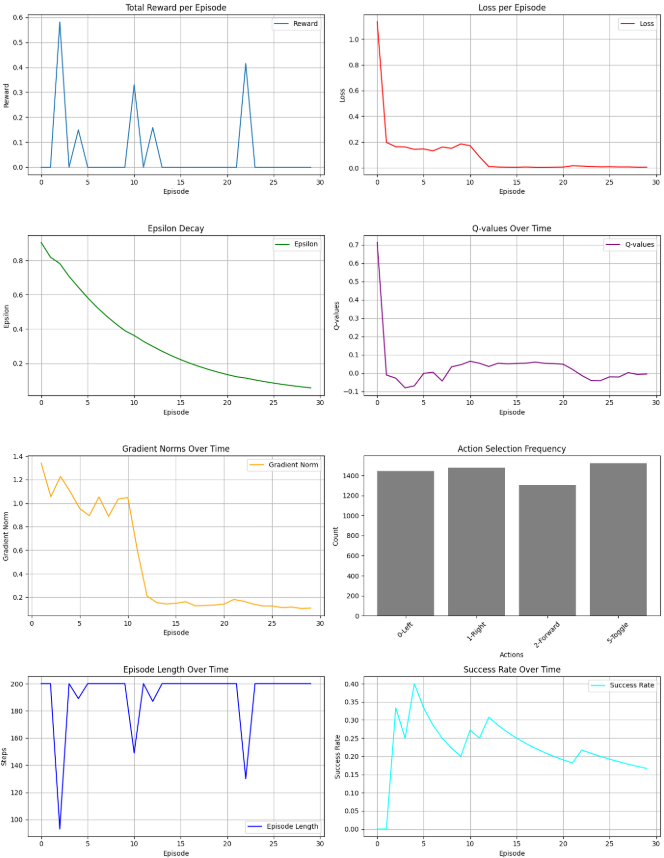


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training_process(training_process: Any, window_size: int = 100) -> None:
    """
    Plots training progress including multiple metrics.

    Parameters:
        training_process (Any): An object containing training logs.
        window_size (int): Window size for computing the rolling success rate.

    Returns:
        None
    """
    fig, axes = plt.subplots(4, 2, figsize=(14, 18))

    # Reward Trend
    if training_process.rewards_log:
        axes[0, 0].plot(training_process.rewards_log, label="Reward")
    axes[0, 0].set_title("Total Reward per Episode")
    axes[0, 0].set_xlabel("Episode")
    axes[0, 0].set_ylabel("Reward")
    axes[0, 0].grid(True)
    axes[0, 0].legend()

    # Loss Trend
    if training_process.loss_log:
        axes[0, 1].plot(training_process.loss_log, color='r', label="Loss")
    axes[0, 1].set_title("Loss per Episode")
    axes[0, 1].set_xlabel("Episode")
    axes[0, 1].set_ylabel("Loss")
    axes[0, 1].grid(True)
    axes[0, 1].legend()

    # Epsilon Decay
    if training_process.epsilon_history:
        axes[1, 0].plot(training_process.epsilon_history, color='g', label="Epsilon")
    axes[1, 0].set_title("Epsilon Decay")
    axes[1, 0].set_xlabel("Episode")
    axes[1, 0].set_ylabel("Epsilon")
    axes[1, 0].grid(True)
    axes[1, 0].legend()

    # Q-values Trend
    if training_process.q_values_history:
        axes[1, 1].plot(training_process.q_values_history, color='purple', label="Q-values")
    axes[1, 1].set_title("Q-values Over Time")
    axes[1, 1].set_xlabel("Episode")
    axes[1, 1].set_ylabel("Q-values")
    axes[1, 1].grid(True)
    axes[1, 1].legend()

    # Gradient Norms
    if training_process.grad_norms:
        axes[2, 0].plot(training_process.grad_norms, color='orange', label="Gradient Norm")
    axes[2, 0].set_title("Gradient Norms Over Time")
    axes[2, 0].set_xlabel("Episode")
    axes[2, 0].set_ylabel("Gradient Norm")
    axes[2, 0].grid(True)
    axes[2, 0].legend()

    # Action Selection Frequency (Handle Empty Dictionary)
    action_mapping = {0: "Left", 1: "Right", 2: "Forward", 5: "Toggle"}
    filtered_actions = {a: count for a, count in training_process.action_counts.items() if a in action_mapping}

    if filtered_actions:  # Only plot if we have data
        action_labels = [f"{a}-{action_mapping[a]}" for a in filtered_actions.keys()]
        action_counts = list(filtered_actions.values())
        axes[2, 1].bar(action_labels, action_counts, color='gray')
        axes[2, 1].set_xticklabels(action_labels, rotation=45)  # Use formatted labels
    
    axes[2, 1].set_title("Action Selection Frequency")
    axes[2, 1].set_xlabel("Actions")
    axes[2, 1].set_ylabel("Count")

    # Episode Length Trend
    if training_process.episode_lengths:
        axes[3, 0].plot(training_process.episode_lengths, color='blue', label="Episode Length")
    axes[3, 0].set_title("Episode Length Over Time")
    axes[3, 0].set_xlabel("Episode")
    axes[3, 0].set_ylabel("Steps")
    axes[3, 0].grid(True)
    axes[3, 0].legend()

    # # Success Rate Trend (Handle Empty List)
    # if training_process.success_rate:
    #     success_avg = [
    #         np.mean(training_process.success_rate[max(0, i - window_size + 1):i + 1])
    #         for i in range(len(training_process.success_rate))
    #     ]
    #     axes[3, 1].plot(range(len(success_avg)), success_avg, color='cyan', label="Success Rate")
    # axes[3, 1].set_title("Success Rate Over Time")
    # axes[3, 1].set_xlabel("Episode")
    # axes[3, 1].set_ylabel("Success Rate")
    # axes[3, 1].grid(True)
    # axes[3, 1].legend()

    # Success Rate Trend (Fix Moving Average Calculation)
    if training_process.success_rate:
        success_avg = []
        for i in range(len(training_process.success_rate)):
            current_window = min(i + 1, window_size)  # Adjust window size for short success lists
            avg_value = np.mean(training_process.success_rate[max(0, i - current_window + 1):i + 1])
            success_avg.append(avg_value)

        axes[3, 1].plot(range(len(success_avg)), success_avg, color='cyan', label="Success Rate")
    axes[3, 1].set_title("Success Rate Over Time")
    axes[3, 1].set_xlabel("Episode")
    axes[3, 1].set_ylabel("Success Rate")
    axes[3, 1].grid(True)
    axes[3, 1].legend()


    plt.tight_layout()
    plt.show()


### Test Training Functions


In [ ]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:

import random
def init_env_DQNagent_train(
                         seed=None,
                         num_rooms=2,
                         max_room_size=4,
                         frames_in_stack=3,
                         downsample_size=(7, 7),
                         gamma=0.99,
                         learning_rate=0.00025,
                         max_epsilon=1.0,
                         epsilon_decay=0.9995,
                         min_epsilon=0.01,
                         target_update_freq=10000,
                         num_episodes=10,
                         max_steps=10000,
                         buffer_size=10,
                         batch_size=32,
                         use_amp=True,
                         log_interval=10,
                         save_video_interval=500,
                         reward_shaping=True,
                         distance_weight=0.1,
                         revisit_penalty=-0.01,
                         door_open_reward=0.5,
                         progress_reward=0.2,
                         ddqn=False,
                         per=False,
                         dueling=False,
                         plot_training = True):
    """Initializes environment, agent, and trainer for training."""
    
    if seed is not None:
        set_seeds(seed)
    else:
        set_seeds(random.randint(0, 1000))


    env, obs = create_multiroom_env(num_rooms, max_room_size,max_steps=max_steps, seed=seed, reward_shaping=reward_shaping, distance_weight=distance_weight, revisit_penalty=revisit_penalty, door_open_reward=door_open_reward, progress_reward=progress_reward)

    agent = DQNAgent(
        frames_in_stack=frames_in_stack,
        downsample_size=downsample_size,
        gamma=gamma,
        lr=learning_rate,
        max_epsilon=max_epsilon,
        epsilon_decay=epsilon_decay,
        min_epsilon=min_epsilon,
        target_update_freq=target_update_freq,
        batch_size=batch_size,
        buffer_size=buffer_size,
        ddqn=ddqn,
        per=per, 
        dueling=dueling,
        use_amp=use_amp, 
        seed=seed

    )
    trainer = Trainer(
        env=env,
        agent=agent,
        num_episodes=num_episodes,
        max_steps=max_steps,
        batch_size=batch_size,
        log_interval=log_interval,
        save_video_interval=save_video_interval
    )

    # Train the agent
    trainer.train()

    if plot_training:
        # Plot training progress
        plot_training_process(trainer)
    
    return env, agent, trainer



Verify that initiallizing the agent, env and training work in all combinationi of dqn:


In [ ]:
# Define test configurations
import itertools
test_configs = list(itertools.product([False, True], repeat=3))  # (ddqn, per, dueling)

# Run tests
for ddqn, per, dueling in test_configs:
    print("\n============================================")
    print(f"🚀 Running Test: ddqn={ddqn}, per={per}, dueling={dueling}")
    print("============================================")

    try:
        # Run training for a small number of episodes
        env, agent, trainer = init_env_DQNagent_train(
            seed=42,
            num_rooms=1,
            max_room_size=4,
            max_steps=20,
            frames_in_stack=3,
            downsample_size=(7, 7),
            gamma=0.99,
            learning_rate=0.00025,
            max_epsilon=1.0,
            epsilon_decay=0.9995,
            min_epsilon=0.05,
            target_update_freq=2000,
            num_episodes=3,  # Small number of episodes
            batch_size=32,
            buffer_size=5000,
            log_interval=1,
            save_video_interval=10,
            ddqn=ddqn,
            per=per,
            dueling=dueling,
            reward_shaping=False,
            plot_training=False,  # No need to plot for quick tests
        )
        print(f"✅ Test PASSED for ddqn={ddqn}, per={per}, dueling={dueling}")
    except Exception as e:
        print(f"❌ Test FAILED for ddqn={ddqn}, per={per}, dueling={dueling}")
        print("Error:", str(e))

In [ ]:
env, agent, trained_mmodel = init_env_DQNagent_train(
                         num_rooms=1,
                         max_room_size=4,
                         num_episodes=5,
                         max_steps=1000,
                         seed=42,
                         frames_in_stack=1,
                         downsample_size=(7, 7),
                         gamma=0.99,
                         learning_rate=0.00025,
                         max_epsilon=1.0,
                         epsilon_decay=0.9995,
                         min_epsilon=0.05,
                         target_update_freq=2000,
                         batch_size=128,
                         use_amp=False,
                         buffer_size=30000,
                         log_interval=1,
                         save_video_interval=5, 
                         ddqn=True,
                         per=True, 
                         dueling=True, 
                         reward_shaping=True,
                         distance_weight=0.0,
                         revisit_penalty=-0.01,
                         door_open_reward=0,
                         progress_reward=0)
                        




#### simple learning - 1 room of 4 with 2-stack framing


In [ ]:
env, agent, trainer = init_env_DQNagent_train(
    seed=43,              # Fix a seed for reproducibility
    num_rooms=1,
    max_room_size=4,
    num_episodes=100,           # Enough to see if it converges
    max_steps=200,              # Smaller steps (it's just 1 room)
    frames_in_stack=2,         # No need for stacking in simplest test
    downsample_size=(4, 4),    # Fine if you want to keep it small
    gamma=0.99,
    learning_rate=0.001,       # Or 2.5e-4 is also common
    max_epsilon=1.0,
    epsilon_decay=0.99,
    min_epsilon=0.1,
    target_update_freq=1000,   # Should be okay for a simple environment
    batch_size=32,             # Smaller batch is plenty in a tiny env
    buffer_size=1000,          # Keep buffer modest
    use_amp=False,             # Off for a small test
    log_interval=5,            # Print logs every 5 episodes
    save_video_interval=50,    # Don’t need a lot of video
    reward_shaping=False,  
    distance_weight=0.0,    # ✅ Ensure no distance shaping
    revisit_penalty=0,    # ✅ Ensure no penalty for loops
    door_open_reward=0.0,   # ✅ Ensure no bonus for doors
    progress_reward=0.0,     # ✅ Ensure no step-based reward    # ✅ Turn OFF shaping for a pure test
    ddqn=False,                # No double DQN for pure baseline
    per=False,                 # No prioritized replay
    dueling=False,             # No dueling network
    plot_training=True         # Let’s see the training curves
)


In [ ]:
env, agent, trainer = init_env_DQNagent_train(
    seed=43,              # Fix a seed for reproducibility
    num_rooms=1,
    max_room_size=4,
    num_episodes=100,           # Enough to see if it converges
    max_steps=200,              # Smaller steps (it's just 1 room)
    frames_in_stack=2,         # No need for stacking in simplest test
    downsample_size=(4, 4),    # Fine if you want to keep it small
    gamma=0.99,
    learning_rate=0.001,       # Or 2.5e-4 is also common
    max_epsilon=1.0,
    epsilon_decay=0.99,
    min_epsilon=0.1,
    target_update_freq=1000,   # Should be okay for a simple environment
    batch_size=32,             # Smaller batch is plenty in a tiny env
    buffer_size=1000,          # Keep buffer modest
    use_amp=False,             # Off for a small test
    log_interval=5,            # Print logs every 5 episodes
    save_video_interval=50,    # Don’t need a lot of video
    reward_shaping=True,  
    distance_weight=0.0,    # ✅ Ensure no distance shaping
    revisit_penalty=0,    # ✅ Ensure no penalty for loops
    door_open_reward=6,   # ✅ Ensure no bonus for doors
    progress_reward=0.0,     # ✅ Ensure no step-based reward    # ✅ Turn OFF shaping for a pure test
    ddqn=False,                # No double DQN for pure baseline
    per=False,                 # No prioritized replay
    dueling=False,             # No dueling network
    plot_training=True         # Let’s see the training curves
)


In [ ]:
import ray
from ray import tune
import itertools

# Define search space
search_space = {
    "gamma": tune.grid_search([0.95, 0.98, 0.99]),
    "learning_rate": tune.grid_search([1e-4, 2.5e-4, 5e-4, 1e-3]),
    "epsilon_decay": tune.grid_search([0.999, 0.9995, 0.9999]),
    "min_epsilon": tune.grid_search([0.01, 0.05]),
    "target_update_freq": tune.grid_search([1000, 2000, 5000]),
    "buffer_size": tune.grid_search([30000, 50000]),
    "batch_size": tune.grid_search([64, 128, 256]),
    "num_episodes": tune.grid_search([100, 200, 500]),
    "max_steps": tune.grid_search([500, 1000])
}

def train_with_params(config):
    env, agent, trainer = init_env_DQNagent_train(
        num_rooms=2,
        max_room_size=4,
        max_steps=config["max_steps"],
        env_seed=None,
        frames_in_stack=3,
        downsample_size=(7, 7),
        gamma=config["gamma"],
        learning_rate=config["learning_rate"],
        max_epsilon=1.0,
        epsilon_decay=config["epsilon_decay"],
        min_epsilon=config["min_epsilon"],
        target_update_freq=config["target_update_freq"],
        num_episodes=config["num_episodes"],
        batch_size=config["batch_size"],
        buffer_size=config["buffer_size"],
        log_interval=10,
        save_video_interval=100, 
        ddqn=True,
        per=True, 
        dueling=True,
    )
    
    return {"reward": sum(trainer.rewards_log[-10:]) / 10}  # Last 10 episode avg

# Run tuning
analysis = tune.run(train_with_params, config=search_space, num_samples=1, resources_per_trial={"gpu": 1})

# Best result
best_trial = analysis.get_best_trial("reward", mode="max", scope="all")
best_params = best_trial.config
print(f"✅ Best Params: {best_params}")


### The Trainnig Process


In [ ]:
import ray
from ray import tune
from ray.tune import CLIReporter  # ✅ Use Ray Tune’s built-in progress bar
from tqdm import tqdm

# Define search space
search_space = {
    "gamma": tune.grid_search([0.95, 0.98, 0.99]),
    "learning_rate": tune.grid_search([1e-4, 2.5e-4, 5e-4, 1e-3]),
    "epsilon_decay": tune.grid_search([0.999, 0.9995, 0.9999]),
    "min_epsilon": tune.grid_search([0.01, 0.05]),
    "target_update_freq": tune.grid_search([1000, 2000, 5000]),
    "buffer_size": tune.grid_search([30000, 50000]),
    "batch_size": tune.grid_search([64, 128, 256]),
    "num_episodes": tune.grid_search([100, 200, 500]),
    "max_steps": tune.grid_search([500, 1000])
}

def train_with_params(config):
    env, agent, trainer = init_env_DQNagent_train(
        num_rooms=2,
        max_room_size=4,
        max_steps=config["max_steps"],
        env_seed=None,
        frames_in_stack=3,
        downsample_size=(7, 7),
        gamma=config["gamma"],
        learning_rate=config["learning_rate"],
        max_epsilon=1.0,
        epsilon_decay=config["epsilon_decay"],
        min_epsilon=config["min_epsilon"],
        target_update_freq=config["target_update_freq"],
        num_episodes=config["num_episodes"],
        batch_size=config["batch_size"],
        buffer_size=config["buffer_size"],
        log_interval=10,
        save_video_interval=100, 
        ddqn=True,
        per=True, 
        dueling=True
    )
    
    return {"reward": sum(trainer.rewards_log[-10:]) / 10}  # Last 10 episode avg

# ✅ Use Ray Tune's built-in CLI progress reporter
reporter = CLIReporter(metric_columns=["reward", "training_iteration"])

# ✅ Remove `tqdm`, and use Ray Tune's reporter
tuner = tune.Tuner(
    train_with_params,
    param_space=search_space,
    run_config=tune.RunConfig(
        progress_reporter=reporter  # ✅ Ray Tune’s own CLI progress bar
    )
)

# Run tuning
results = tuner.fit()

# Get the best parameters
best_result = results.get_best_result(metric="reward", mode="max")
print(f"✅ Best hyperparameters found: {best_result.config}")


In [ ]:
import torch; print(torch.cuda.is_available(), torch.cuda.get_device_name(0))